In [61]:
import dask

from cartopy import crs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xclim as xc
import xscen as xs

In [2]:
dask.config.set(num_workers=12, scheduler='processes')

In [3]:
manic = {
    'name': 'Manic',
    'method': 'bbox',
    'bbox': {
        'lat_bnds': [47, 54],
        'lon_bnds': [-72, -65]
    }
}
pt = {'lat': 51.4, 'lon': -68.15}

In [4]:
cat_ref = xs.DataCatalog('/tank/scenario/catalogues/reconstruction.json')
cat_eg6 = xs.DataCatalog('/crue/jlavoie/ESPO-G6/extractamno_version/cat_ESPO-G6_extractamno.json')
cat_ind = xs.DataCatalog('/home/pbourg/Projets/scenario-web/backend/config/catalog.json')
cat_raw = xs.DataCatalog('/tank/scenario/catalogues/simulation.json')
scat = cat_ind.search(bias_adjust_project='ESPO-G6', xrfreq='AS-JAN', experiment='ssp245')

In [5]:
#scat.keys()

In [6]:
elem = scat['ESPO-G6_CMIP6_ScenarioMIP_BCC_BCC-CSM2-MR_ssp245_r1i1p1f1_NAM.NAM.indicators.AS-JAN'].df.iloc[0]

In [7]:
_, elem_raw = xs.search_data_catalogs(
    cat_raw, 
    {'tasmin': 'D', 'tasmax': 'D'},
    other_search_criteria=dict(elem[['mip_era', 'institution', 'source', 'member', 'experiment']]),
    allow_resampling=False,
    allow_conversion=False,
    match_hist_and_fut=True
).popitem()
dsraw = xs.extract_dataset(
    elem_raw,
    region=manic,
    xr_open_kwargs={'chunks': {'lat': 80}},
    xr_combine_kwargs={'data_vars': 'minimal', 'coords': 'minimal'},
)['D']

2023-03-01 09:01:10,262 - xscen.extract - INFO - Catalog opened: < catalog with 1337 dataset(s) from 142969 asset(s)> from 1 files.
2023-03-01 09:01:10,264 - xscen.extract - INFO - Dispatching historical dataset to future experiments.
2023-03-01 09:01:27,879 - xscen.extract - INFO - 34 assets matched the criteria : {'mip_era': 'CMIP6', 'institution': 'BCC', 'source': 'BCC-CSM2-MR', 'member': 'r1i1p1f1', 'experiment': 'ssp245'}.
2023-03-01 09:01:27,889 - xscen.extract - INFO - Iterating over 1 potential datasets.
2023-03-01 09:01:28,002 - xscen.extract - INFO - Found 1 with all variables requested and corresponding to the criteria.


In [8]:
dsraw = dsraw.sel(time=slice('1950', '2100'))
raw = xr.Dataset({
    'dlyfrzthw': xc.atmos.daily_freezethaw_cycles(ds=dsraw, freq='YS'),
    'dtr_mean': xc.atmos.daily_temperature_range(ds=dsraw, freq='YS')
})

In [9]:
ba = cat_ind.search(
    variable=['dtr_mean', 'dlyfrzthw'],
    domain='NAM',
    processing_level='indicators',
    xrfreq='AS-JAN', 
    **dict(elem[['mip_era', 'institution', 'source', 'member', 'experiment']])
).to_dataset(xarray_open_kwargs={'decode_timedelta': False})
ba = xs.extract.clisops_subset(ba, manic)

In [10]:
_, elem_ref = xs.search_data_catalogs(
    cat_ref, 
    {'tasmin': 'D', 'tasmax': 'D'},
    other_search_criteria={'source': 'ERA5-Land'},
    allow_resampling=False,
    allow_conversion=False,
).popitem()
dsref = xs.extract_dataset(
    elem_ref,
    region=manic,
    xr_combine_kwargs={'data_vars': 'minimal', 'coords': 'minimal'},
)['D']

2023-03-01 09:02:32,189 - xscen.extract - INFO - Catalog opened: < catalog with 6 dataset(s) from 21157 asset(s)> from 1 files.
2023-03-01 09:02:32,217 - xscen.extract - INFO - 9584 assets matched the criteria : {'source': 'ERA5-Land'}.
2023-03-01 09:02:32,233 - xscen.extract - INFO - Iterating over 1 potential datasets.
2023-03-01 09:02:32,449 - xscen.extract - INFO - Found 1 with all variables requested and corresponding to the criteria.


In [11]:
ref = cat_ind.search(
    variable=['dtr_mean', 'dlyfrzthw'],
    domain='NAM',
    processing_level='indicators',
    xrfreq='AS-JAN', 
    source='ERA5-Land'
).to_dataset(xarray_open_kwargs={'decode_timedelta': False})
ref = xs.extract.clisops_subset(ref, manic)

In [12]:
_, elem_ba = xs.search_data_catalogs(
    cat_eg6, 
    {'tasmin': 'D', 'tasmax': 'D'},
    other_search_criteria={
        'processing_level': 'final',
        'domain': 'NAM',
        **dict(elem[['mip_era', 'institution', 'source', 'member', 'experiment']])
    },
    allow_resampling=False,
    allow_conversion=False,
).popitem()
dsba = xs.extract_dataset(
    elem_ba,
    region=manic,
    xr_combine_kwargs={'data_vars': 'minimal', 'coords': 'minimal'},
)['D']

2023-03-01 09:02:44,988 - xscen.extract - INFO - Catalog opened: <cat_ESPO-G6_extractamno catalog with 2674 dataset(s) from 3017 asset(s)> from 1 files.
2023-03-01 09:02:45,015 - xscen.extract - INFO - 1 assets matched the criteria : {'processing_level': 'final', 'domain': 'NAM', 'mip_era': 'CMIP6', 'institution': 'BCC', 'source': 'BCC-CSM2-MR', 'member': 'r1i1p1f1', 'experiment': 'ssp245'}.
2023-03-01 09:02:45,027 - xscen.extract - INFO - Iterating over 1 potential datasets.
2023-03-01 09:02:45,191 - xscen.extract - INFO - Found 1 with all variables requested and corresponding to the criteria.


In [13]:
dsref = dsref.assign(dtr=(dsref.tasmax - dsref.tasmin).rename('dtr'))
dsba = dsba.assign(dtr=(dsba.tasmax - dsba.tasmin).rename('dtr'))
dsraw = dsraw.assign(dtr=(dsraw.tasmax - dsraw.tasmin).rename('dtr'))

In [14]:
ref = ref.convert_calendar('noleap')
raw = raw.convert_calendar('noleap')
ba = ba.convert_calendar('noleap')
dsref = dsref.convert_calendar('noleap')
dsraw = dsraw.convert_calendar('noleap')
dsba = dsba.convert_calendar('noleap')

In [49]:
dsreg = xs.regrid_dataset(dsraw, dsref, '/exec/pbourg/temp/', regridder_kwargs={'method': 'bilinear'})
dsraw['lon'] = dsraw.lon - 360

In [16]:
with dask.diagnostics.ProgressBar():
    ref, raw, ba, dsref, dsraw, dsba, dsreg = dask.compute(ref, raw, ba, dsref, dsraw, dsba, dsreg)

[########################################] | 100% Completed | 138.34 s


In [17]:
bins = np.linspace(220, 305, 86)
centers = (bins[:-1] + bins[1:]) / 2

def _pdf(da):
    return xr.DataArray(
        np.histogram(da, bins)[0] / da.size, dims=('temp',), coords={'temp': centers}
    )

def yrpdf(da):
    daDJF = da #xc.core.calendar.select_time(da, season='DJF')
    time = da.resample(time='YS').first().time
    out = daDJF.resample(time='AS-DEC').map(_pdf)
    if out.time.size != time.size:
        out = out.isel(time=slice(None, -1))
    return out.assign_coords(time=time).rename(f"{da.name}_pdf")

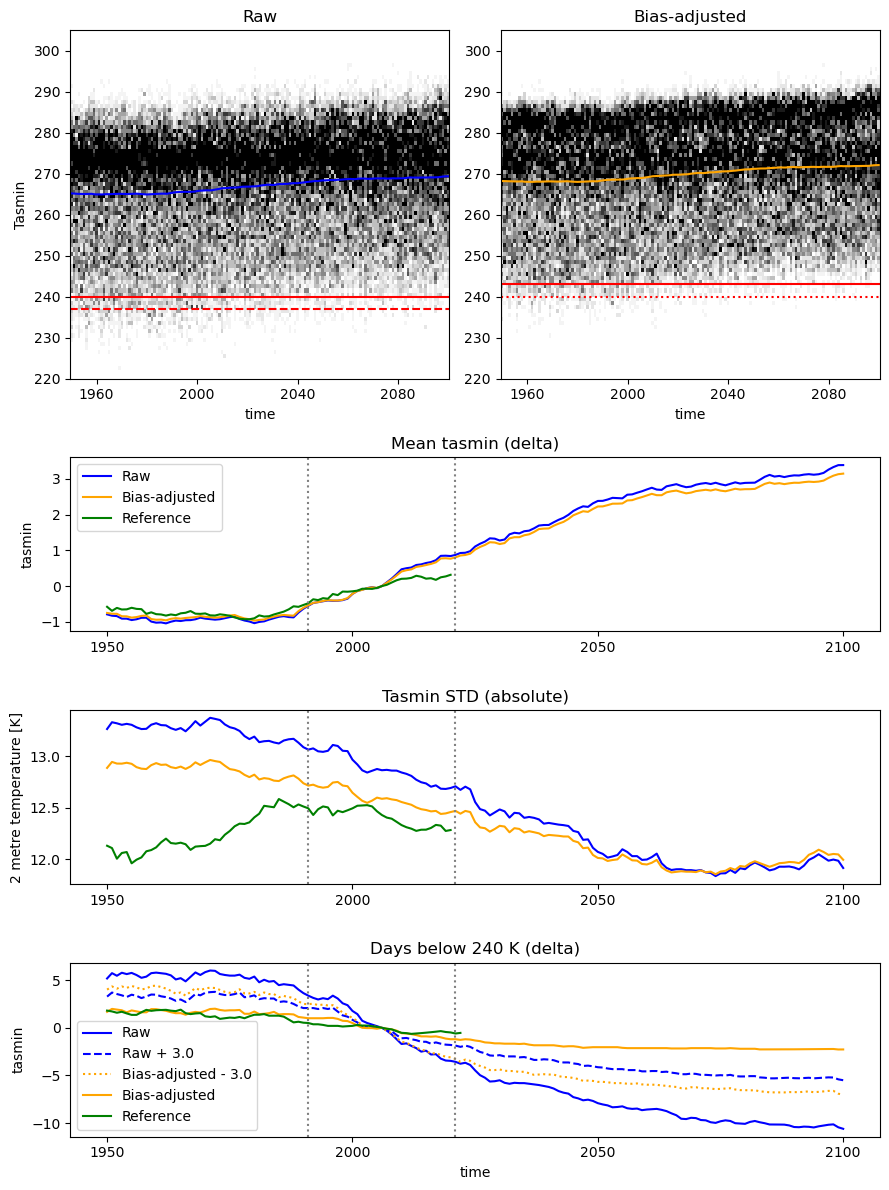

In [99]:
delta = lambda da: da - da.sel(time=slice('1991', '2020')).mean('time')
roll = lambda da: da.rolling(time=30, center=True, min_periods=5).mean()
colors = ['blue', 'orange', 'green']

dw = dsraw.tasmin.sel(lat=pt['lat'], lon=pt['lon'], method='nearest')
df = dsref.tasmin.sel(**pt, method='nearest')
db = dsba.tasmin.sel(**pt, method='nearest')

t = 240
d = (db.sel(time=slice('1991', '2020')) - dw.sel(time=slice('1991', '2020'))).mean().item()

fig = plt.figure(figsize=(9, 12))
gs = plt.GridSpec(4, 2, height_ratios=[2, 1, 1, 1])

# PDF
axPR = plt.subplot(gs[0, 0])
(
    yrpdf(dw)
    .plot(x='time', y='temp', ax=axPR, vmax=0.03, add_colorbar=False, cmap=plt.cm.Greys)
)
(
    dw
    .resample(time='YS').mean()
    .pipe(roll)
    .plot(ax=axPR, label='Raw', color=colors[0])
)
axPR.axhline(t, color='r', label=f'{t} K')
axPR.axhline(t - d, color='r', linestyle='--', label=f'{t - d} K')
axPR.set_ylabel('Tasmin')
axPR.set_title('Raw')

axPB = plt.subplot(gs[0, 1])
(
    yrpdf(db)
    .plot(x='time', y='temp', ax=axPB, vmax=0.03, add_colorbar=False, cmap=plt.cm.Greys)
)
(
    db
    .resample(time='YS').mean()
    .pipe(roll)
    .plot(ax=axPB, label='Bias-adjusted', color=colors[1])
)
axPB.axhline(t + d, color='r', label=f'{t + d} K')
axPB.axhline(t, color='r', linestyle=':', label=f'{t} K')
axPB.set_ylabel('')
axPB.set_title('Bias-adjusted')

# tn_mean
axTM = plt.subplot(gs[1, :])
(
    dw
    .resample(time='YS').mean()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTM, label='Raw', color=colors[0])
)
(
    db
    .resample(time='YS').mean()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTM, label='Bias-adjusted', color=colors[1])
)
(
    df
    .sel(time=slice('1950-01-01', '2020-12-31'))
    .resample(time='YS').mean()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTM, label='Reference', color=colors[2])
)
axTM.axvline(df.sel(time='1991-01-01').indexes['time'][0], linestyle=':', color='grey')
axTM.axvline(df.sel(time='2020-12-31').indexes['time'][0], linestyle=':', color='grey')
axTM.legend()
axTM.set_title('Mean tasmin (delta)')
axTM.set_xlabel('')

# tn_std
axTS = plt.subplot(gs[2, :])
(
    dw
    .resample(time='YS').std()
    #.pipe(delta)
    .pipe(roll)
    .plot(ax=axTS, label='Raw', color=colors[0])
)
(
    db
    .resample(time='YS').std()
    #.pipe(delta)
    .pipe(roll)
    .plot(ax=axTS, label='Bias-adjusted', color=colors[1])
)
(
    df
    .sel(time=slice('1950-01-01', '2020-12-31'))
    .resample(time='YS').std()
    #.pipe(delta)
    .pipe(roll)
    .plot(ax=axTS, label='Reference', color=colors[2])
)
axTS.axvline(df.sel(time='1991-01-01').indexes['time'][0], linestyle=':', color='grey')
axTS.axvline(df.sel(time='2020-12-31').indexes['time'][0], linestyle=':', color='grey')
axTS.set_title('Tasmin STD (absolute)')
axTS.set_xlabel('')

# tn days below
axTB = plt.subplot(gs[3, :])
(
    (dw < t)
    .resample(time='YS').sum()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTB, label=f'Raw', color=colors[0])
)
(
    ((dw + d) < t)
    .resample(time='YS').sum()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTB, label=f'Raw + {d:.1f}', linestyle='--', color=colors[0])
)
(
    ((db - d) < t)
    .resample(time='YS').sum()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTB, label=f'Bias-adjusted - {d:.1f}', linestyle=':', color=colors[1])
)
(
    (db < t)
    .resample(time='YS').sum()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTB, label=f'Bias-adjusted', color=colors[1])
)

(
    (df < t)
    .resample(time='YS').sum()
    .pipe(delta)
    .pipe(roll)
    .plot(ax=axTB, label=f'Reference', color=colors[2])
)
axTB.axvline(df.sel(time='1991-01-01').indexes['time'][0], linestyle=':', color='grey')
axTB.axvline(df.sel(time='2020-12-31').indexes['time'][0], linestyle=':', color='grey')
axTB.legend(loc='lower left')
axTB.set_title(f'Days below 240 K (delta)')
fig.tight_layout()
fig.savefig('Threshold_indicators.pdf')

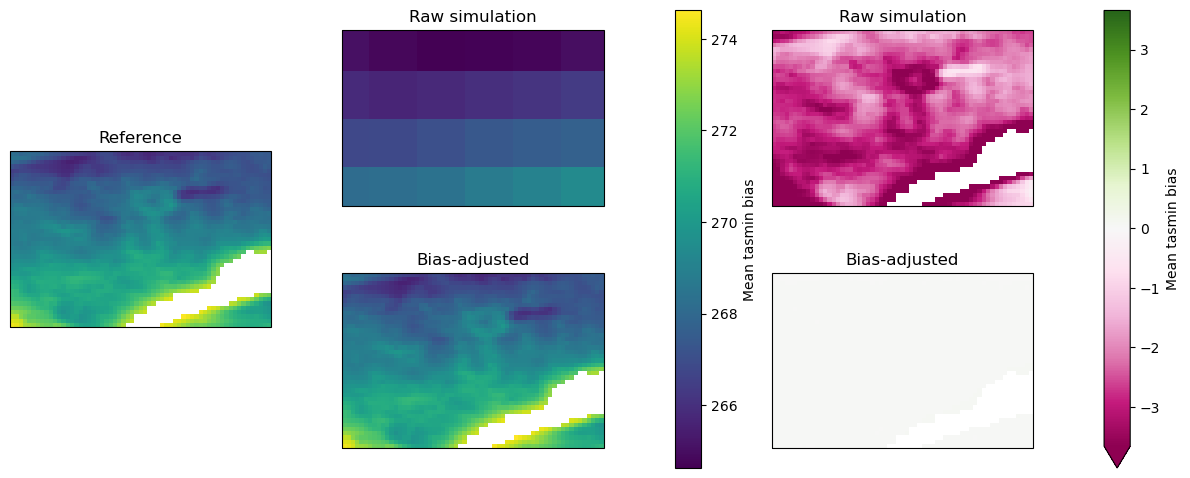

In [102]:
m ={'lat': slice(48.5, 52.5), 'lon': slice(-72, -66)}
fig = plt.figure(figsize=(12, 5))
gs = plt.GridSpec(4, 5, width_ratios=[1, 1, 0.1, 1, 0.1])

dw = dsraw.tasmin.sel(time=slice('1991', '2020'), **m).mean('time')
dg = dsreg.tasmin.sel(time=slice('1991', '2020'), **m).mean('time')
df = dsref.tasmin.sel(time=slice('1991', '2020'), **m).mean('time')
da = dsba.tasmin.sel(time=slice('1991', '2020'), **m).mean('time')

vmin = min(dw.min(), df.min(), da.min())
vmax = max(dw.max(), df.max(), da.max())

axRF = plt.subplot(gs[1:3, 0], projection=crs.PlateCarree())
m = df.plot(ax=axRF, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axRF.set_title('Reference')

axRW = plt.subplot(gs[:2, 1], projection=crs.PlateCarree())
dw.plot(ax=axRW, vmin=vmin, vmax=vmax, add_colorbar=False)
axRW.set_extent(axRF.get_extent())
axRW.set_title('Raw simulation')

axBA = plt.subplot(gs[2:, 1], projection=crs.PlateCarree())
da.plot(ax=axBA, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axBA.set_title('Bias-adjusted')

fig.colorbar(m, cax=plt.subplot(gs[:, 2]), label='Mean tasmin bias')

bw = dg - df
ba = da - df

vmax = max(abs(bw).quantile(0.9), abs(ba).quantile(0.9))
vmin = -vmax

axdRW = plt.subplot(gs[:2, 3], projection=crs.PlateCarree())
m = bw.plot(ax=axdRW, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdRW.set_title('Raw simulation')

axdBA = plt.subplot(gs[2:, 3], projection=crs.PlateCarree())
ba.plot(ax=axdBA, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdBA.set_title('Bias-adjusted')

fig.colorbar(m, cax=plt.subplot(gs[:, 4]), label='Mean tasmin bias', extend='min')
fig.tight_layout()
fig.savefig('Tasmin_mean_bias.pdf')

In [ ]:
m ={'lat': slice(48.5, 52.5), 'lon': slice(-72, -66)}
fig = plt.figure(figsize=(12, 5))
gs = plt.GridSpec(4, 5, width_ratios=[1, 1, 0.1, 1, 0.1])

dw = dsraw.tasmin.sel(time=slice('1991', '2020'), **m).std('time')
dg = dsreg.tasmin.sel(time=slice('1991', '2020'), **m).std('time')
df = dsref.tasmin.sel(time=slice('1991', '2020'), **m).std('time')
da = dsba.tasmin.sel(time=slice('1991', '2020'), **m).std('time')

vmin = min(dw.min(), df.min(), da.min())
vmax = max(dw.max(), df.max(), da.max())

axRF = plt.subplot(gs[1:3, 0], projection=crs.PlateCarree())
m = df.plot(ax=axRF, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axRF.set_title('Reference')

axRW = plt.subplot(gs[:2, 1], projection=crs.PlateCarree())
dw.plot(ax=axRW, vmin=vmin, vmax=vmax, add_colorbar=False)
axRW.set_extent(axRF.get_extent())
axRW.set_title('Raw simulation')

axBA = plt.subplot(gs[2:, 1], projection=crs.PlateCarree())
da.plot(ax=axBA, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axBA.set_title('Bias-adjusted')

fig.colorbar(m, cax=plt.subplot(gs[:, 2]), label='Tasmin STD')

bw = dg - df
ba = da - df

vmax = max(abs(bw).quantile(0.9), abs(ba).quantile(0.9))
vmin = -vmax

axdRW = plt.subplot(gs[:2, 3], projection=crs.PlateCarree())
m = bw.plot(ax=axdRW, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdRW.set_title('Raw simulation')

axdBA = plt.subplot(gs[2:, 3], projection=crs.PlateCarree())
ba.plot(ax=axdBA, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdBA.set_title('Bias-adjusted')

fig.colorbar(m, cax=plt.subplot(gs[:, 4]), label='Tasmin STD bias', extend='max')
fig.tight_layout()
fig.savefig('Tasmin_STD_bias.pdf')

,unique
id,3
type,1
processing_level,1
bias_adjust_institution,0
bias_adjust_project,0
mip_era,0
activity,0
driving_institution,0
driving_model,0
institution,1


In [106]:
_, elem_rdr = xs.search_data_catalogs(
    '/exec/pbourg/catalogues/reconstruction-extra.json', 
    {'tasmin': 'D', 'tasmax': 'D'},
    other_search_criteria={'source': 'RDRS'},
    allow_resampling=False,
    allow_conversion=False,
).popitem()
dsrdr = xs.extract_dataset(
    elem_rdr,
    region=manic,
    xr_combine_kwargs={'data_vars': 'minimal', 'coords': 'minimal'},
)['D'].load()

2023-03-01 15:45:04,117 - xscen.extract - INFO - Catalog opened: < catalog with 2 dataset(s) from 6 asset(s)> from 1 files.
2023-03-01 15:45:04,143 - xscen.extract - INFO - 6 assets matched the criteria : {'source': 'RDRS'}.
2023-03-01 15:45:04,157 - xscen.extract - INFO - Iterating over 1 potential datasets.
2023-03-01 15:45:04,299 - xscen.extract - INFO - Found 1 with all variables requested and corresponding to the criteria.


/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


In [112]:
dsrnr = xr.open_mfdataset(
    '/tank/scenario/netcdf/nrcan/nrcan_canada_daily/tasm*/*.nc',
    data_vars='minimal',
    coords='minimal',
    drop_variables=['ts', 'time_vectors']
)
dsrnr = xs.extract.clisops_subset(dsrnr, manic)

In [129]:
_, elem_era = xs.search_data_catalogs(
    cat_ref, 
    {'tasmin': 'D', 'tasmax': 'D'},
    other_search_criteria={'source': 'ERA5'},
    allow_resampling=False,
    allow_conversion=False,
).popitem()
dsera = xs.extract_dataset(
    elem_era,
    region=manic,
    xr_combine_kwargs={'data_vars': 'minimal', 'coords': 'minimal'},
)['D']

2023-03-01 16:03:13,791 - xscen.extract - INFO - Catalog opened: < catalog with 6 dataset(s) from 21157 asset(s)> from 1 files.
2023-03-01 16:03:13,858 - xscen.extract - INFO - 10268 assets matched the criteria : {'source': 'ERA5'}.
2023-03-01 16:03:13,871 - xscen.extract - INFO - Iterating over 1 potential datasets.
2023-03-01 16:03:15,286 - xscen.extract - INFO - Found 1 with all variables requested and corresponding to the criteria.


In [130]:
era5 = xs.regrid_dataset(dsera, dsref, '/exec/pbourg/temp/')
nrcan = xs.regrid_dataset(dsrnr, dsref, '/exec/pbourg/temp/')
rdrs = xs.regrid_dataset(dsrdr, dsref, '/exec/pbourg/temp/')

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.


In [131]:
rdrs.load()
nrcan.load()
era5.load()

<xarray.Dataset>
Dimensions:  (time: 26571, lat: 71, lon: 71)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-09-30
  * lat      (lat) float32 47.0 47.1 47.2 47.3 47.4 ... 53.6 53.7 53.8 53.9 54.0
  * lon      (lon) float32 -72.0 -71.9 -71.8 -71.7 ... -65.3 -65.2 -65.1 -65.0
Data variables:
    tasmax   (time, lat, lon) float32 nan 269.2 nan nan ... 281.8 281.6 nan nan
    tasmin   (time, lat, lon) float32 nan 258.5 nan nan ... 278.0 278.0 nan nan
Attributes: (12/32)
    data_specs_version:                 00.00.07
    domain:                             NAM
    format:                             zarr
    frequency:                          day
    institution:                        ECMWF
    processing_level:                   raw
    ...                                 ...
    cat:frequency:                      day
    history:                            [2023-03-01 16:03:30] regridded with ...
    cat:domain:                         Manic
    cat:processing_level:               regridded
    cat:variable:                       ('tasmax', 'tasmin')
    regrid_method:                      bilinear

In [119]:
rdrs

<xarray.Dataset>
Dimensions:  (time: 14245, lat: 71, lon: 71)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
  * lat      (lat) float32 47.0 47.1 47.2 47.3 47.4 ... 53.6 53.7 53.8 53.9 54.0
  * lon      (lon) float32 -72.0 -71.9 -71.8 -71.7 ... -65.3 -65.2 -65.1 -65.0
Data variables:
    tasmax   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tasmin   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/37)
    Conventions:                        CF-1.8
    Remarks:                            Original variable names are following...
    data_specs_version:                 00.00.08
    doi:                                https://doi.org/10.5194/hess-25-4917-...
    frequency:                          day
    history:                            [2023-03-01 15:51:54] regridded with ...
    ...                                 ...
    cat:xrfreq:                         D
    cat:frequency:                      day
    cat:domain:                         Manic
    cat:processing_level:               regridded
    cat:variable:                       ('tasmax', 'tasmin')
    regrid_method:                      bilinear

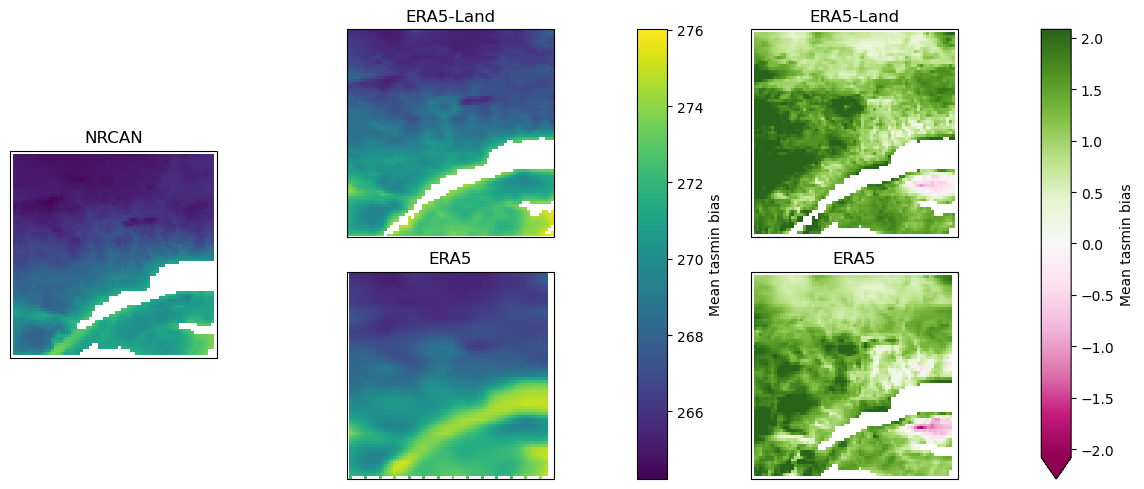

In [132]:
m = {}
fig = plt.figure(figsize=(12, 5))
gs = plt.GridSpec(4, 5, width_ratios=[1, 1, 0.1, 1, 0.1])

df = nrcan.tasmin.sel(time=slice('1981', '2010'), **m).mean('time')
da = era5.tasmin.sel(time=slice('1981', '2010'), **m).mean('time')
dw = dsref.tasmin.sel(time=slice('1981', '2010'), **m).mean('time')
ft = 'NRCAN'
at = 'ERA5'
wt = 'ERA5-Land'

vmin = min(dw.min(), df.min(), da.min())
vmax = max(dw.max(), df.max(), da.max())

axRF = plt.subplot(gs[1:3, 0], projection=crs.PlateCarree())
m = df.plot(ax=axRF, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axRF.set_title(ft)

axRW = plt.subplot(gs[:2, 1], projection=crs.PlateCarree())
dw.plot(ax=axRW, vmin=vmin, vmax=vmax, add_colorbar=False)
axRW.set_extent(axRF.get_extent())
axRW.set_title(wt)

axBA = plt.subplot(gs[2:, 1], projection=crs.PlateCarree())
da.plot(ax=axBA, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axBA.set_title(at)

fig.colorbar(m, cax=plt.subplot(gs[:, 2]), label='Mean tasmin bias')

bw = dw - df
ba = da - df

vmax = max(abs(bw).quantile(0.9), abs(ba).quantile(0.9))
vmin = -vmax

axdRW = plt.subplot(gs[:2, 3], projection=crs.PlateCarree())
m = bw.plot(ax=axdRW, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdRW.set_title(wt)

axdBA = plt.subplot(gs[2:, 3], projection=crs.PlateCarree())
ba.plot(ax=axdBA, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdBA.set_title(at)

fig.colorbar(m, cax=plt.subplot(gs[:, 4]), label='Mean tasmin bias', extend='min')
fig.tight_layout()
fig.savefig('Tasmin_mean_REFS.pdf')

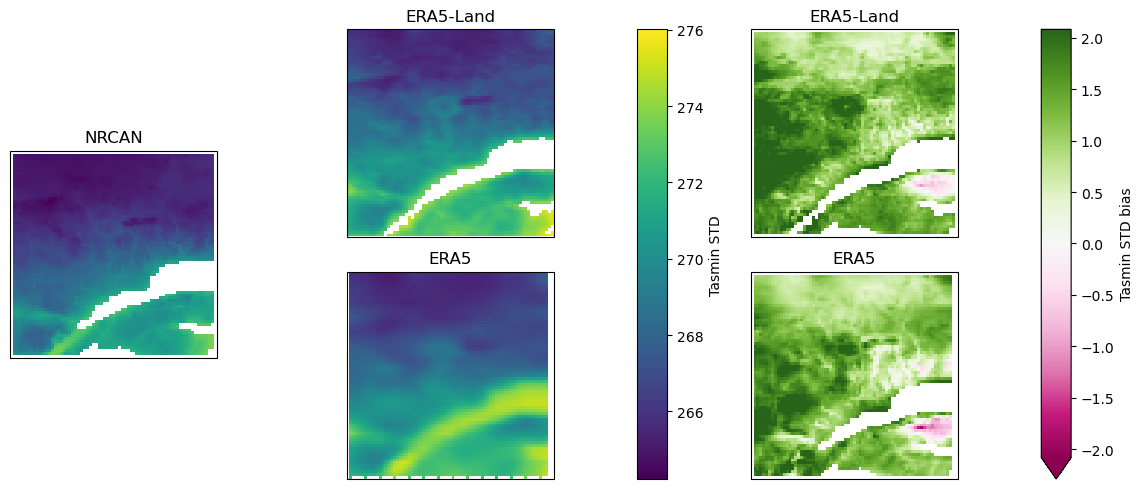

In [133]:
m = {}
fig = plt.figure(figsize=(12, 5))
gs = plt.GridSpec(4, 5, width_ratios=[1, 1, 0.1, 1, 0.1])

df = nrcan.tasmin.sel(time=slice('1981', '2010'), **m).mean('time')
da = era5.tasmin.sel(time=slice('1981', '2010'), **m).mean('time')
dw = dsref.tasmin.sel(time=slice('1981', '2010'), **m).mean('time')
ft = 'NRCAN'
at = 'ERA5'
wt = 'ERA5-Land'

vmin = min(dw.min(), df.min(), da.min())
vmax = max(dw.max(), df.max(), da.max())

axRF = plt.subplot(gs[1:3, 0], projection=crs.PlateCarree())
m = df.plot(ax=axRF, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axRF.set_title(ft)

axRW = plt.subplot(gs[:2, 1], projection=crs.PlateCarree())
dw.plot(ax=axRW, vmin=vmin, vmax=vmax, add_colorbar=False)
axRW.set_extent(axRF.get_extent())
axRW.set_title(wt)

axBA = plt.subplot(gs[2:, 1], projection=crs.PlateCarree())
da.plot(ax=axBA, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
axBA.set_title(at)

fig.colorbar(m, cax=plt.subplot(gs[:, 2]), label='Tasmin STD')

bw = dw - df
ba = da - df

vmax = max(abs(bw).quantile(0.9), abs(ba).quantile(0.9))
vmin = -vmax

axdRW = plt.subplot(gs[:2, 3], projection=crs.PlateCarree())
m = bw.plot(ax=axdRW, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdRW.set_title(wt)

axdBA = plt.subplot(gs[2:, 3], projection=crs.PlateCarree())
ba.plot(ax=axdBA, vmin=vmin, vmax=vmax, add_colorbar=False, cmap=plt.cm.PiYG, rasterized=True)
axdBA.set_title(at)

fig.colorbar(m, cax=plt.subplot(gs[:, 4]), label='Tasmin STD bias', extend='min')
fig.tight_layout()
fig.savefig('Tasmin_std_REFS.pdf')

# DLYFRZTHW

In [1]:
import dask
from dask.diagnostics import ProgressBar
from datatree import DataTree
import itertools as it
from pathlib import Path
import geopandas as gpd
from clisops.core.subset import create_weight_masks, subset_bbox
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
import xarray as xr
import xclim as xc
import xclim.ensembles as xce
import xesmf as xe
import xscen as xs

2023-05-02 10:29:30,600 - pint.util - WARNING - Redefining 'year' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,603 - pint.util - WARNING - Redefining 'yr' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,606 - pint.util - WARNING - Redefining 'C' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,611 - pint.util - WARNING - Redefining 'd' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,615 - pint.util - WARNING - Redefining 'h' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,618 - pint.util - WARNING - Redefining 'degrees_north' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,621 - pint.util - WARNING - Redefining 'degrees_east' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-05-02 10:29:30,625 - pint.util - WARNING - Redefining '[speed]' (<class 'pint.delegates.txt_d

In [2]:
dask.config.set(num_workers=20)
ProgressBar().register()

In [4]:
root = Path('/exec/pbourg/ESPO-G/indsanal/')
probreg = dict(
    name="prob-reg",
    method="bbox",
    bbox=dict(
        lat_bnds=[45, 47],
        lon_bnds=[-75, -70]
    ),
)
regions = gpd.read_file('/exec/pbourg/PC/20230406/regions_simplified_admin.geojson')
estrie = regions.iloc[[29]]
estrie

,id,name,geometry
29,30,Estrie,"POLYGON ((-71.06889 45.92744, -71.05771 45.938..."


In [5]:
def as_delta(da):
    return da - da.sel(time=slice('1991', '2020')).mean('time')

In [27]:
# ESPO-G
scats = xs.search_data_catalogs(
    '/jarre/scenario/jlavoie/ESPO-G6/cat_ESPO-G6_RDRS.json',
    variables_and_freqs={'tasmin': 'D', 'tasmax': 'D', 'dtr': 'D'},
    other_search_criteria=dict(
        processing_level='final', source=['CMCC-ESM2', 'CNRM-ESM2-1', 'MPI-ESM1-2-LR'],
        experiment=['ssp245', 'ssp370'], domain='QC-rdrs'
    ),
    match_hist_and_fut=True,
    allow_conversion=True,
)
for dsid, scat in scats.items():
    print('Processing', dsid)
    outfile = Path(f'/exec/pbourg/ESPO-G/indsanal/day_ESPO-G6_{dsid}_prob-reg.zarr')
    if outfile.is_dir():
        print('done')
        continue
    ds = xs.extract_dataset(
        scat,
        region=probreg,
        xr_open_kwargs={'engine': 'zarr', 'use_cftime': True},
        xr_combine_kwargs={'coords': 'minimal', 'data_vars': 'minimal', 'compat': 'override'}
    )['D']
    ds.cf.chunk({'X': -1, 'Y': -1}).to_zarr(outfile)

2023-03-27 13:29:45,931 - xscen.extract - INFO - Catalog opened: <cat_ESPO-G6_extractamno catalog with 668 dataset(s) from 684 asset(s)> from 1 files.
2023-03-27 13:29:45,932 - xscen.extract - INFO - Dispatching historical dataset to future experiments.
2023-03-27 13:29:46,277 - xscen.extract - INFO - 6 assets matched the criteria : {'processing_level': 'final', 'source': ['CMCC-ESM2', 'CNRM-ESM2-1', 'MPI-ESM1-2-LR'], 'experiment': ['ssp245', 'ssp370'], 'domain': 'QC-rdrs'}.
2023-03-27 13:29:46,291 - xscen.extract - INFO - Iterating over 6 potential datasets.
2023-03-27 13:29:48,532 - xscen.extract - INFO - Found 6 with all variables requested and corresponding to the criteria.
Processing CMIP6_ScenarioMIP_CMCC_CMCC-ESM2_ssp245_r1i1p1f1_global
[########################################] | 100% Completed | 685.28 ms
[                                        ] | 0% Completed | 112.94 ms

/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


[########################################] | 100% Completed | 6.94 sms
[########################################] | 100% Completed | 36.19 s
Processing CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp245_r1i1p1f2_global
done
Processing CMIP6_ScenarioMIP_CMCC_CMCC-ESM2_ssp370_r1i1p1f1_global
done
Processing CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp370_r1i1p1f2_global
done
Processing CMIP6_ScenarioMIP_MPI-M_MPI-ESM1-2-LR_ssp370_r1i1p1f1_global
done
Processing CMIP6_ScenarioMIP_MPI-M_MPI-ESM1-2-LR_ssp245_r1i1p1f1_global
done


In [73]:
#RDRS
scats = xs.search_data_catalogs(
    '/tank/scenario/catalogues/reconstruction-extra.json',
    variables_and_freqs={'tasmin': 'D', 'tasmax': 'D', 'dtr': 'D'},
    other_search_criteria=dict(source='RDRS'),
    allow_conversion=True,
)
for dsid, scat in scats.items():
    print('Processing', dsid)
    outfile = Path(f'/exec/pbourg/ESPO-G/indsanal/day_RDRS_prob-reg.zarr')
    if outfile.is_dir():
        print('done')
        continue
    ds = xs.extract_dataset(
        scat,
        region=probreg,
        xr_open_kwargs={'engine': 'zarr', 'use_cftime': True},
        xr_combine_kwargs={'coords': 'minimal', 'data_vars': 'minimal', 'compat': 'override'}
    )['D']
    ds.cf.chunk({'X': -1, 'Y': -1}).to_zarr(outfile)

2023-03-27 17:24:13,768 - xscen.extract - INFO - Catalog opened: < catalog with 4 dataset(s) from 868 asset(s)> from 1 files.
2023-03-27 17:24:13,798 - xscen.extract - INFO - 8 assets matched the criteria : {'source': 'RDRS'}.
2023-03-27 17:24:13,816 - xscen.extract - INFO - Iterating over 1 potential datasets.
2023-03-27 17:24:14,263 - xscen.extract - INFO - Found 1 with all variables requested and corresponding to the criteria.
Processing GouvCan_RDRS_NAM
[########################################] | 100% Completed | 322.51 ms
[###                                     ] | 8% Completed | 113.07 ms

/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


[########################################] | 100% Completed | 945.75 ms
[########################################] | 100% Completed | 7.44 ss


In [20]:
for zarr in root.glob('day_CanDCS-U6_CMIP6*MIROC*ok-reg.zarr'):
    print(zarr)
    outpath = zarr.parent / zarr.name.replace('day_', 'yr_')
    if outpath.is_dir():
        print('Skipping', zarr)
        continue
    ds = xr.open_zarr(zarr)
    if 'rotated_pole' in ds:
        ds = ds.update(xs.regrid.create_bounds_rotated_pole(ds))
    out = xr.merge(
        [
            xc.atmos.daily_freezethaw_cycles(ds=ds, freq='MS'),
            xc.atmos.daily_temperature_range(ds=ds, freq='MS'),
            create_weight_masks(ds, estrie).squeeze('geom', drop=True).rename('mask')
        ]
    ).chunk({'time': -1})
    print(zarr)
    out.to_zarr(outpath)

/exec/pbourg/ESPO-G/indsanal/day_CanDCS-U6_CMIP6_ScenarioMIP_MIROC6_MIROC6_ssp245_r1i1p1f1_CAN_ok-reg.zarr
/exec/pbourg/ESPO-G/indsanal/day_CanDCS-U6_CMIP6_ScenarioMIP_MIROC6_MIROC6_ssp245_r1i1p1f1_CAN_ok-reg.zarr
[########################################] | 100% Completed | 30.91 s
/exec/pbourg/ESPO-G/indsanal/day_CanDCS-U6_CMIP6_ScenarioMIP_MIROC_MIROC6_ssp245_r1i1p1f1_CAN_ok-reg.zarr
Skipping /exec/pbourg/ESPO-G/indsanal/day_CanDCS-U6_CMIP6_ScenarioMIP_MIROC_MIROC6_ssp245_r1i1p1f1_CAN_ok-reg.zarr


In [7]:
dd = {}
def squeeze_time(ds):
    if 'mask' in ds.data_vars and 'time' in ds.mask.dims:
        return ds.assign(mask=ds.mask.isel(time=0))
    return ds

for zarr in root.glob('day_*.zarr'):
    parts = zarr.stem.split('_')
    dom = parts[-1]
    if parts[1].startswith('CanDCS'):
        src = 'pcic'
        mip = parts[2]
        mod = parts[5]
        if mip == 'CMIP5':
            scen = f"rcp{parts[6][-2:]}"
        else:
            scen = parts[6]
    elif parts[2] == 'MRCC5':
        src = 'mrcc5'
        mip = parts[1]
        mod = parts[3]
        scen = parts[6]
    elif parts[1].startswith('CMIP'):
        src = 'raw'
        mip = parts[1]
        mod = parts[4]
        scen = parts[5]
    elif parts[1] == 'ScenGen':
        src = parts[1]
        mip = parts[2]
        mod = parts[4]
        scen = parts[5]
    elif parts[1] == 'ESPO-TN':
        src = parts[1]
        mip = parts[2]
        mod = parts[5]
        scen = parts[6]
    elif parts[1] == 'RDRS':
        continue
    else:
        src = parts[1]
        mip = parts[2]
        mod = parts[5]
        scen = parts[6]
    
    dd[f'{dom}/day/{mip}/{mod}/{scen}/{src}'] = xr.open_zarr(
        zarr, use_cftime=True
    ).convert_calendar('noleap', align_on='year')
    yrpath = zarr.parent / zarr.name.replace('day_', 'yr_')
    if yrpath.is_dir():
        dd[f'{dom}/mon/{mip}/{mod}/{scen}/{src}'] = squeeze_time(
            xr.open_zarr(
                yrpath,
                use_cftime=True,
                decode_timedelta=False
            ).convert_calendar('noleap', align_on='date')
        )

In [8]:
dt = DataTree.from_dict(dd)

In [9]:
rdrs_mon = xr.open_zarr('/exec/pbourg/ESPO-G/indsanal/yr_RDRS_prob-reg.zarr/', decode_timedelta=False)

In [10]:
parts = {}
for leaf in dt['prob-reg']['mon'].leaves:
    for nm, part in zip(['mip', 'mod', 'scen', 'src'], leaf.path.split('/')[2:]):
        parts.setdefault(nm, set()).add(part)
parts

{'mip': {'mon'},
 'mod': {'CMIP5', 'CMIP6'},
 'scen': {'ACCESS-CM2',
  'ACCESS-ESM1-5',
  'BCC-CSM2-MR',
  'BNU-ESM',
  'CMCC-CMS',
  'CMCC-ESM2',
  'CNRM-ESM2-1',
  'CanESM2',
  'FGOALS-g3',
  'GFDL-ESM2M',
  'GFDL-ESM4',
  'HadGEM2-CC',
  'INM-CM4',
  'INM-CM5-0',
  'IPSL-CM5A-LR',
  'IPSL-CM5B-LR',
  'KACE-1-0-G',
  'MIROC6',
  'MPI-ESM-LR',
  'MPI-ESM1-2-HR',
  'MPI-ESM1-2-LR',
  'MRI-ESM2-0',
  'NorESM1-M',
  'NorESM2-LM'},
 'src': {'rcp45', 'ssp126', 'ssp245', 'ssp370'}}

[########################################] | 100% Completed | 310.89 ms
[########################################] | 100% Completed | 103.60 ms
[########################################] | 100% Completed | 205.28 ms
[########################################] | 100% Completed | 310.16 ms
[########################################] | 100% Completed | 205.67 ms
[########################################] | 100% Completed | 104.51 ms
[########################################] | 100% Completed | 103.34 ms
[########################################] | 100% Completed | 307.76 ms
[########################################] | 100% Completed | 107.51 ms
[########################################] | 100% Completed | 309.10 ms
[########################################] | 100% Completed | 206.12 ms
[########################################] | 100% Completed | 105.34 ms
[########################################] | 100% Completed | 205.33 ms
[########################################] | 100% Completed | 31

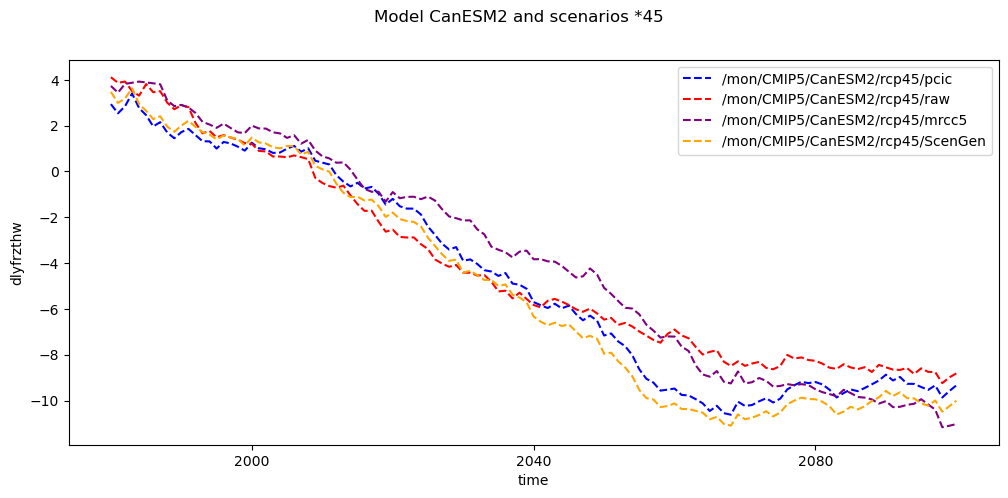

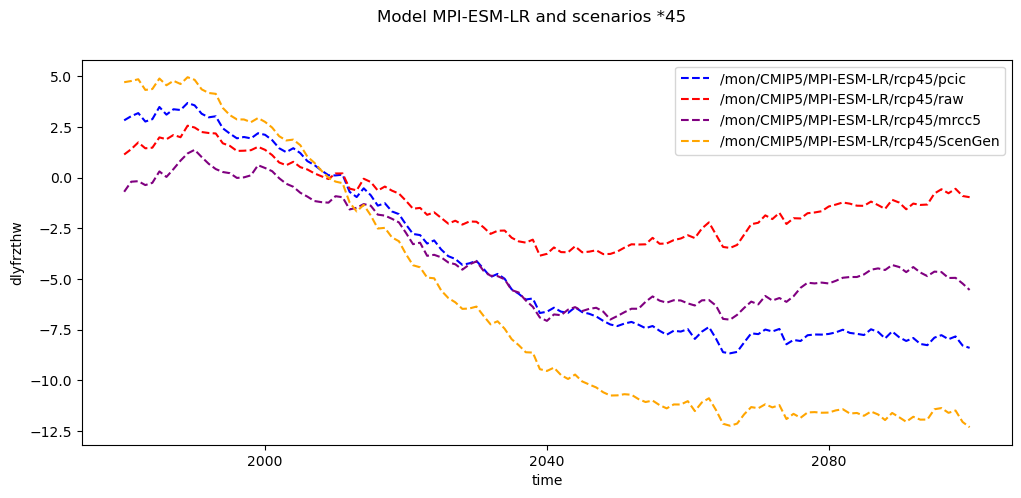

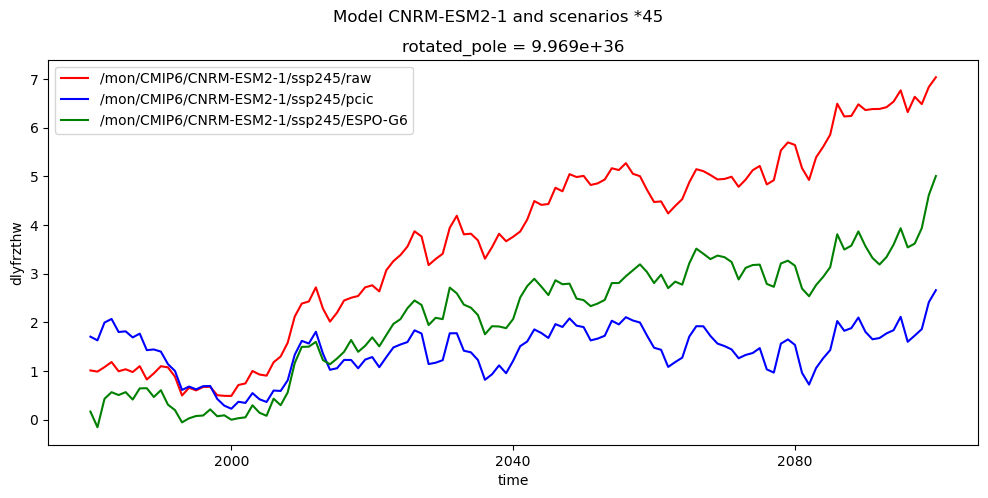

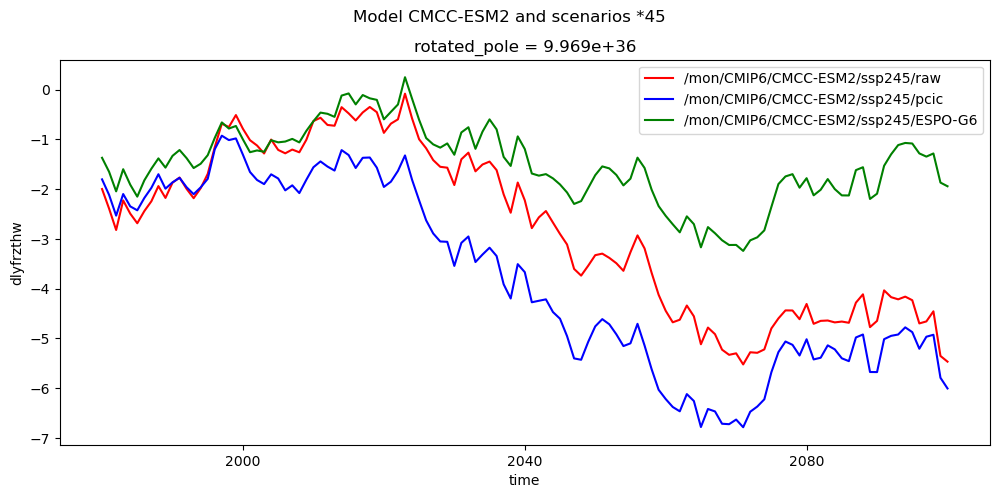

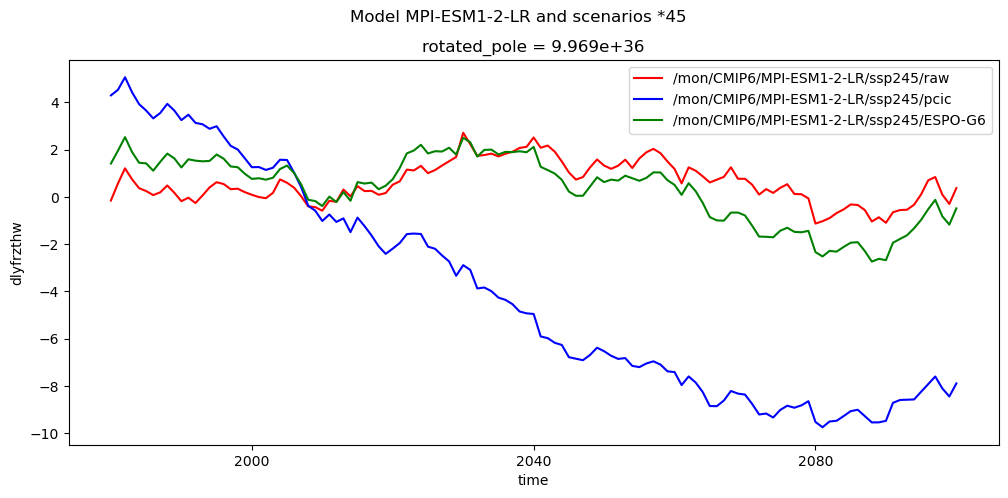

In [65]:
for mod, scn in it.product(parts['mod'], ['45']):
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.suptitle(f'Model {mod} and scenarios *{scn}')
    colors = {'pcic': 'b', 'raw': 'r', 'ESPO-G6': 'g', 'ScenGen': 'orange', 'mrcc5': 'purple'}
    for leaf in dt['prob-reg']['mon'].leaves:
        if not leaf.parent.parent.name == mod or not leaf.parent.name.endswith(scn):
            continue
        (
            leaf['dlyfrzthw']
            .sel(time=slice('1980', '2100'))
            .resample(time='YS').sum()
            .pipe(as_delta)
            .weighted(leaf['mask']).mean(leaf['mask'].dims)
            .rolling(time=50, center=True, min_periods=15).mean()
            .plot(
                ax=ax,
                label=str(leaf.path),
                color=colors[leaf.name],
                linestyle='--' if 'CMIP5' in leaf.path else '-'
            )
        )
    ax.legend()

[########################################] | 100% Completed | 103.75 ms
[########################################] | 100% Completed | 308.57 ms
[########################################] | 100% Completed | 204.74 ms
[########################################] | 100% Completed | 113.27 ms
[########################################] | 100% Completed | 306.86 ms
[########################################] | 100% Completed | 307.52 ms
[########################################] | 100% Completed | 104.80 ms
[########################################] | 100% Completed | 307.67 ms
[########################################] | 100% Completed | 309.59 ms


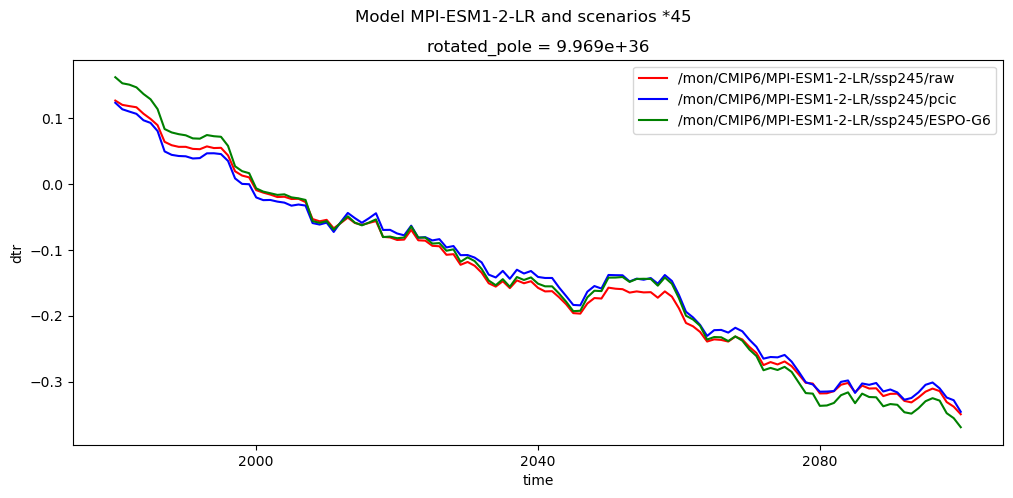

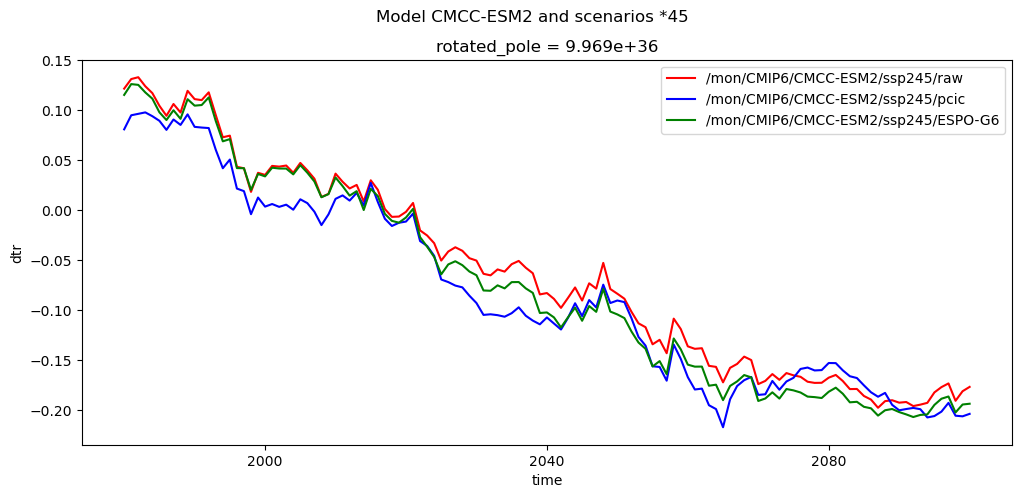

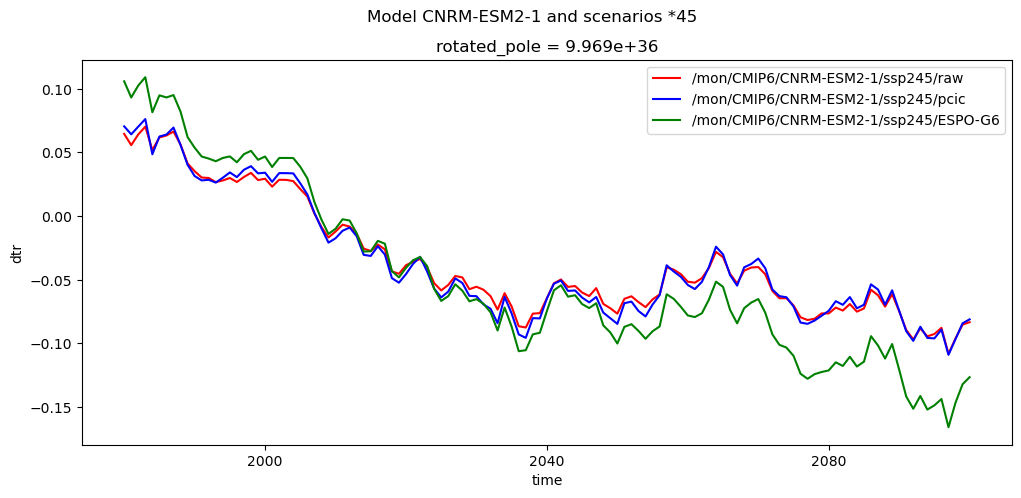

In [64]:
for mod, scn in it.product({'CMCC-ESM2', 'CNRM-ESM2-1', 'MPI-ESM1-2-LR'}, ['45']):
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.suptitle(f'Model {mod} and scenarios *{scn}')
    colors = {'pcic': 'b', 'raw': 'r', 'ESPO-G6': 'g', 'ScenGen': 'orange', 'mrcc5': 'purple'}
    for leaf in dt['prob-reg']['mon'].leaves:
        if not leaf.parent.parent.name == mod or not leaf.parent.name.endswith(scn):
            continue
        (
            leaf['dtr']
            .sel(time=slice('1980', '2100'))
            .resample(time='YS').mean()
            .pipe(as_delta)
            .weighted(leaf['mask']).mean(leaf['mask'].dims)
            .rolling(time=50, center=True, min_periods=15).mean()
            .plot(
                ax=ax,
                label=str(leaf.path),
                color=colors[leaf.name],
                linestyle='--' if 'CMIP5' in leaf.path else '-'
            )
        )
    ax.legend()

[########################################] | 100% Completed | 102.92 ms
2023-03-27 17:33:33,089 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:33,093 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[########################################] | 100% Completed | 102.45 ms
2023-03-27 17:33:33,272 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:33,278 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all par

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.


[########################################] | 100% Completed | 104.42 ms
2023-03-27 17:33:35,222 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:35,227 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[########################################] | 100% Completed | 103.74 ms
2023-03-27 17:33:35,449 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:35,454 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all par

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.


[########################################] | 100% Completed | 104.28 ms
2023-03-27 17:33:37,638 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:37,643 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[########################################] | 100% Completed | 103.30 ms
2023-03-27 17:33:37,862 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:37,868 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all par

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.


[########################################] | 100% Completed | 103.80 ms
2023-03-27 17:33:39,369 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:39,374 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[########################################] | 100% Completed | 103.07 ms
2023-03-27 17:33:39,564 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:39,566 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all par

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.


[########################################] | 100% Completed | 102.92 ms
2023-03-27 17:33:40,994 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:41,001 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[########################################] | 100% Completed | 104.31 ms
2023-03-27 17:33:41,252 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-27 17:33:41,256 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all par

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.


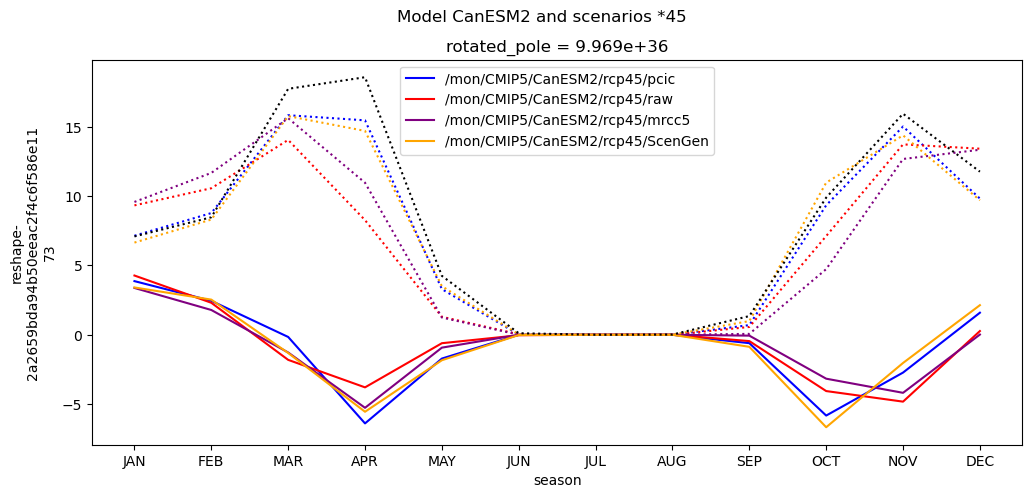

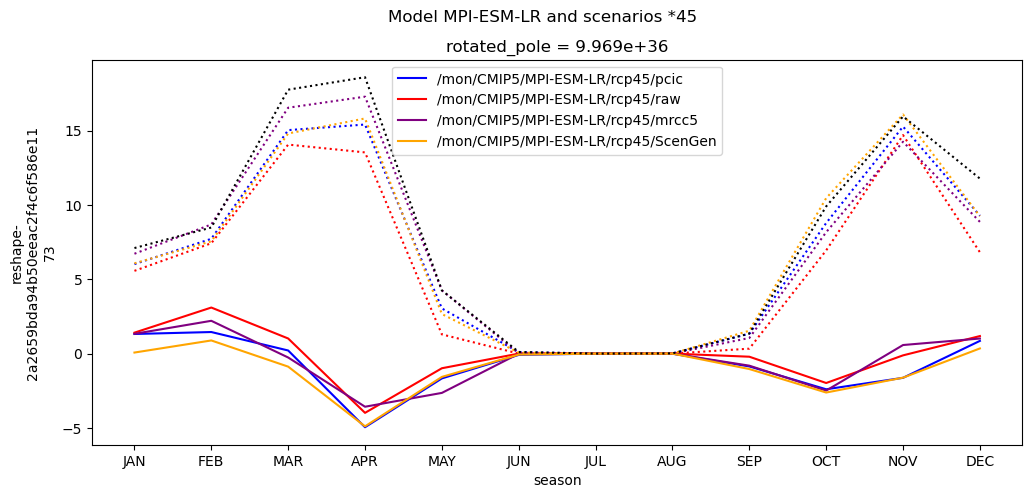

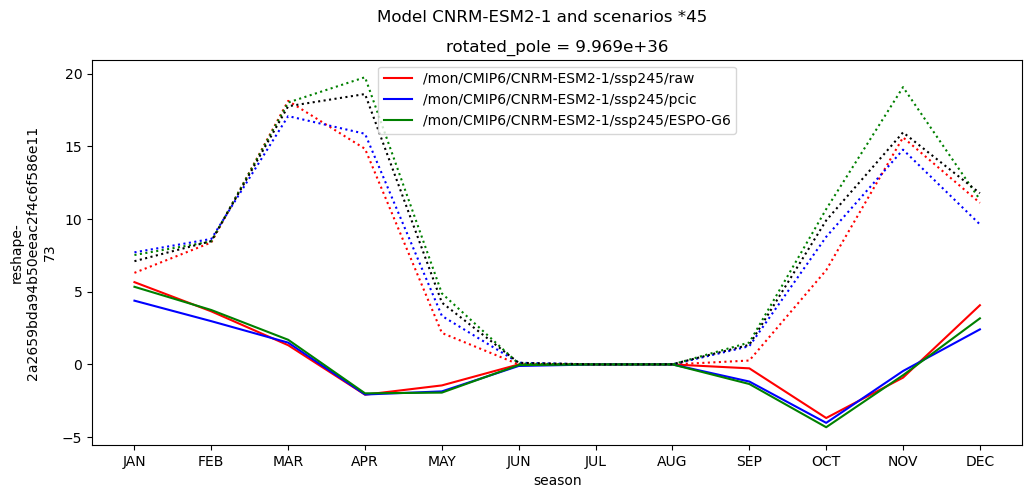

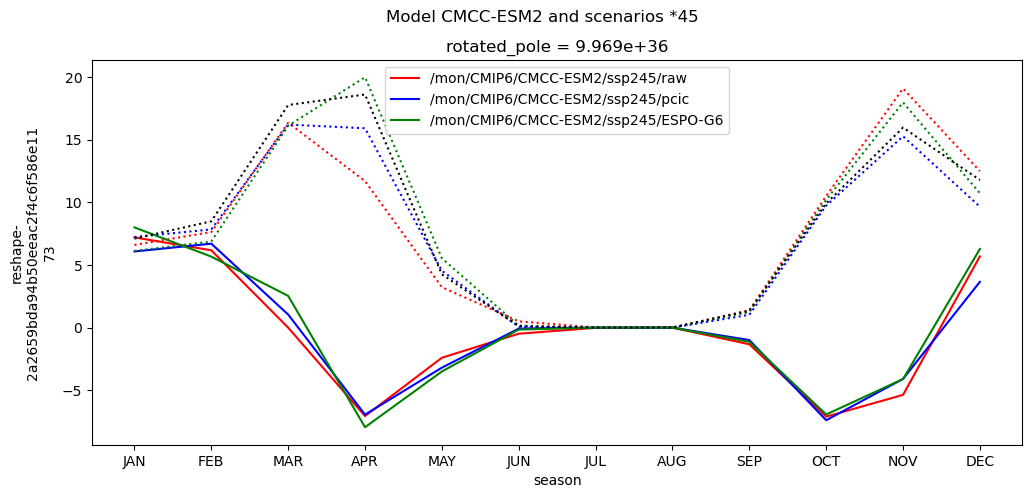

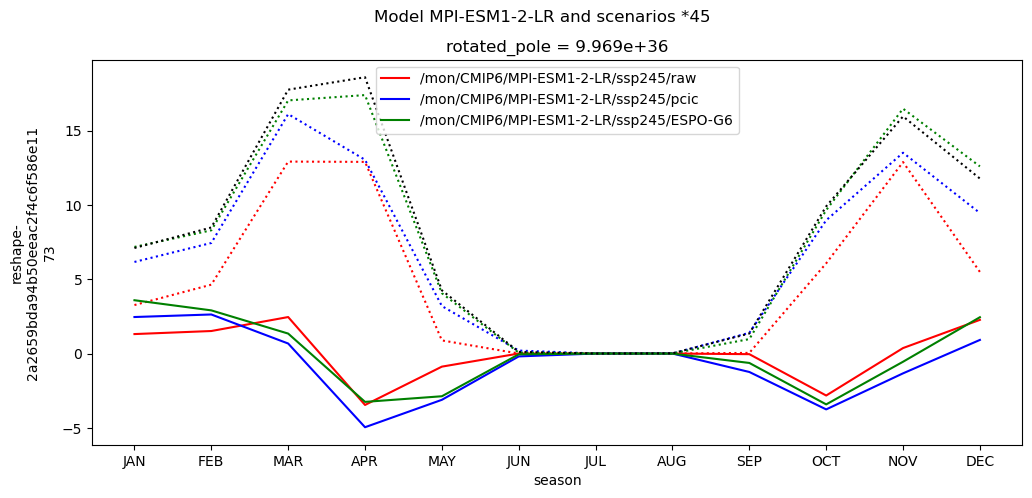

In [79]:
for mod, scn in it.product(parts['mod'], ['45']):
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.suptitle(f'Model {mod} and scenarios *{scn}')
    colors = {'pcic': 'b', 'raw': 'r', 'ESPO-G6': 'g', 'ScenGen': 'orange', 'mrcc5': 'purple'}
    for leaf in dt['prob-reg']['mon'].leaves:
        if not leaf.parent.parent.name == mod or not leaf.parent.name.endswith(scn):
            continue
        (
            leaf['dlyfrzthw']
            .pipe(xs.utils.unstack_dates)
            .pipe(as_delta)
            .weighted(leaf['mask']).mean(leaf['mask'].dims)
            .sel(time=slice('2071', '2100')).mean('time')
            .plot(
                ax=ax,
                label=str(leaf.path),
                color=colors[leaf.name],
            )
        )
        (
            leaf['dlyfrzthw']
            #.pipe(as_delta)
            .weighted(leaf['mask']).mean(leaf['mask'].dims)
            .sel(time=slice('1991', '2020'))
            .pipe(xs.utils.unstack_dates)
            .mean('time')
            .plot(
                ax=ax,
                #label=str(leaf.path),
                linestyle=':',
                color=colors[leaf.name],
            )
        )
    (
        rdrs_mon['dlyfrzthw']
        #.pipe(as_delta)
        .weighted(rdrs_mon['mask']).mean(rdrs_mon['mask'].dims)
        .sel(time=slice('1991', '2020'))
        .pipe(xs.utils.unstack_dates)
        .mean('time')
        .plot(
            ax=ax,
            #label=str(leaf.path),
            linestyle=':',
            color='k',
        )
    )
    ax.legend()
    

## Delta de Gel dégel

In [10]:
def delta(ds):
    return ds.sel(time=slice('2071', '2100')).mean('time') - ds.sel(time=slice('1981', '2010')).mean('time')

In [11]:
# CMIP6 raw
raw = {
    leaf.parent.parent.name: leaf.to_dataset()
    for leaf in dt['prob-reg']['mon']['CMIP6'].leaves
    if leaf.name == 'raw' and leaf.parent.name == 'ssp245'
}

ens = xce.create_ensemble(
    {
        real: (
            ds
            .dlyfrzthw.resample(time='YS').sum()
            #.weighted(ds.mask).mean(ds.mask.dims)
            .mean(ds.mask.dims)
        )
        for real, ds in raw.items()
    }
)

dftraw = (
    ens
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 225.75 ms


In [12]:
# CMIP6 raw
raw = {
    leaf.parent.parent.name: leaf.to_dataset()
    for leaf in dt['prob-reg']['mon']['CMIP5'].leaves
    if leaf.name == 'raw' and leaf.parent.name == 'rcp45'
}

ens = xce.create_ensemble(
    {
        real: (
            ds
            .dlyfrzthw.resample(time='YS').sum()
            #.weighted(ds.mask)
            .mean(ds.mask.dims)
        )
        for real, ds in raw.items()
    }
)

dftraw5 = (
    ens
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 212.86 ms


In [13]:
# CanDCS-U6
pcic = {
    leaf.parent.parent.name: leaf.to_dataset()
    for leaf in dt['prob-reg']['mon']['CMIP6'].leaves
    if leaf.name == 'pcic' and leaf.parent.name == 'ssp245'
}

ens = xce.create_ensemble(pcic)

dftpcic = (
    ens
    .dlyfrzthw.resample(time='YS').sum()
    #.weighted(ens.mask)
    .mean(['lat', 'lon'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 708.17 ms


In [14]:
# CanDCS-U5
pcic5 = {
    leaf.parent.parent.name: leaf.to_dataset()
    for leaf in dt['prob-reg']['mon']['CMIP5'].leaves
    if leaf.name == 'pcic' and leaf.parent.name == 'rcp45'
}

ens = xce.create_ensemble(pcic5)

dftpcic5 = (
    ens
    .dlyfrzthw.resample(time='YS').sum()
    #.weighted(ens.mask)
    .mean(['lat', 'lon'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 1.03 sms


In [15]:
# ESPO-Tmin
espotn = {
    leaf.parent.parent.name: leaf.to_dataset()
    for leaf in dt['prob-reg']['mon']['CMIP6'].leaves
    if leaf.name == 'ESPO-TN' and leaf.parent.name == 'ssp245'
}

ens = xce.create_ensemble(espotn)

dftegtn = (
    ens
    .dlyfrzthw.resample(time='YS').sum()
    #.weighted(ens.mask)
    .mean(['rlat', 'rlon'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 102.43 ms
[########################################] | 100% Completed | 101.88 ms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 106.96 ms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 101.81 ms
[########################################] | 100% Completed | 101.73 ms
[########################################] | 100% Completed | 101.87 ms
[########################################] | 100% Completed | 101.99 ms
[########################################] | 100% Completed | 101.80 ms
[########################################] | 100% Completed | 102.07 ms
[########################################] | 100% Completed | 101.63 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 10

In [16]:
# ESPO-G6-R2
ens = (
    xs.DataCatalog('/jarre/scenario/jlavoie/ESPO-G6/cat_ESPO-G6_RDRS.json')
    .search(domain='QC-rdrs', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal'}
    )
)
#ens = (
#    ens
#    .update(xs.regrid.create_bounds_rotated_pole(ens))
#    .cf.chunk({'X': -1, 'Y': -1, 'bounds': -1})
#)
dfteg6r = (
    #xe.SpatialAverager(ens, regions.geometry)(ens)
    xs.extract.clisops_subset(ens, region=probreg)
    .cf.mean(['X', 'Y'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 7.22 ss
[                                        ] | 0% Completed | 108.65 ms

/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


[########################################] | 100% Completed | 15.27 s
[########################################] | 100% Completed | 3.46 ss


In [17]:
# ESPO-G6-E5L
ens = (
    xs.DataCatalog('/jarre/scenario/jlavoie/ESPO-G6/cat_ESPO-G6_extractamno.json')
    .search(domain='NAM', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False}
    )
)
#ens = (
#    ens
#    .sel(lon=slice(-83, -55), lat=slice(42, 63))
#    # .update(xs.regrid.create_bounds_rotated_pole(ens))
#    .chunk({'lon': -1, 'lat': -1}) #, 'bounds': -1})
#)
dfteg6e = (
    #xe.SpatialAverager(ens, regions.geometry)(ens)
    xs.extract.clisops_subset(ens, region=probreg)
    .mean(['lat', 'lon'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 7.74 ss
[########################################] | 100% Completed | 2.23 ss


In [18]:
# ESPO-G6-N1
ens = (
    xs.DataCatalog('/exec/pbourg/ESPO-G/cat_ESPO-G6.json')
    .search(domain='QC-nrcan', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False}
    )
)
ens = (
    ens
    # .sel(lon=slice(-83, -55), lat=slice(42, 63))
    # .update(xs.regrid.create_bounds_rotated_pole(ens))
    #.chunk({'lon': -1, 'lat': -1}) #, 'bounds': -1})
)
dfteg6n = (
    #xe.SpatialAverager(ens, regions.geometry)(ens)
    xs.extract.clisops_subset(ens, region=probreg)
    .cf.mean(['X', 'Y'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 6.25 ss
[########################################] | 100% Completed | 5.68 ss


In [19]:
# ScenGen
ens = (
    xs.DataCatalog('/tank/scenario/catalogues/ESPO-extra.json')
    .search(experiment='rcp45', variable='dlyfrzthw', xrfreq='AS-JAN', bias_adjust_project='ScenGen')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False}
    )
)
#ens = (
#    ens
#    .sel(lon=slice(-83, -55), lat=slice(63, 42))
    # .update(xs.regrid.create_bounds_rotated_pole(ens))
#    .chunk({'lon': -1, 'lat': -1}) #, 'bounds': -1})
#)
dftSG = (
    #xe.SpatialAverager(ens, regions.geometry)(ens)
    xs.extract.clisops_subset(ens, region=probreg)
    .cf.mean(['X', 'Y'])
    .pipe(delta)
    .load()
)

[########################################] | 100% Completed | 1.93 ss
[########################################] | 100% Completed | 1.26 sms


In [23]:
dfts = [dftraw5.dlyfrzthw, dftSG.dlyfrzthw, dftpcic5, dftraw.dlyfrzthw, dftpcic, dftegtn, dfteg6r.dlyfrzthw, dfteg6e.dlyfrzthw, dfteg6n.dlyfrzthw]
sources = ['raw5', 'ScenGen', 'PCIC5', 'raw', 'PCIC', 'EG6-Tmin', 'EG6-RDRS', 'EG6-ERA5-Land', 'EG6-NRCAN']
colors =  ['red', 'red', 'red', 'blue', 'green', 'violet', 'purple', 'purple', 'purple']

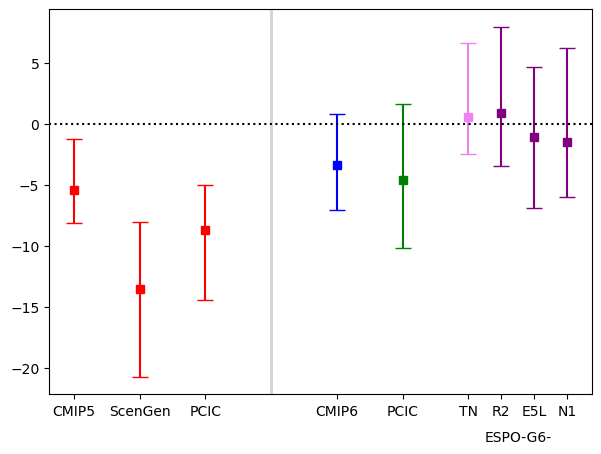

In [46]:
dftsq = xr.concat(
    [dd.quantile([0.1, 0.5, 0.9], 'realization') for dd in dfts],
    xr.DataArray(sources, dims=('source',), name='source')
)
yerr = abs(dftsq.sel(quantile=0.5) - dftsq.sel(quantile=[0.1, 0.9])).T
fig, ax = plt.subplots(figsize=(7, 5))
for srcs, pos, col in (
    (['raw5', 'ScenGen', 'PCIC5'], [-3, -2, -1], 'red'),
    (['raw'], [1], 'blue'),
    (['PCIC'], [2], 'green'),
    (['EG6-Tmin'], [3], 'violet'),
    (['EG6-RDRS', 'EG6-ERA5-Land', 'EG6-NRCAN'], [3.5, 4, 4.5], 'purple')
):
    ax.errorbar(pos, dftsq.sel(quantile=0.5, source=srcs), yerr=yerr.sel(source=srcs),
                fmt='s', color=col, capsize=6)
ax.axvline(0, color='lightgray', linewidth=2)
ax.axhline(0, color='k', linestyle=':')
ax.set_xticks([-3, -2, -1, 1, 2, 3, 3.5, 4, 4.5])
ax.set_xticklabels(['CMIP5', 'ScenGen', 'PCIC', 'CMIP6', 'PCIC', 'TN', 'R2', 'E5L', 'N1'])
ax.text(3.25, -26, 'ESPO-G6-')
ax.set_title('')
fig.savefig('Delta_prob-reg_All.png', bbox_inches='tight')

Text(0.5, 1.0, 'Delta des cycles de Gel-Dégel dans la région problématique - 1981-2010 vs 2071-2100')

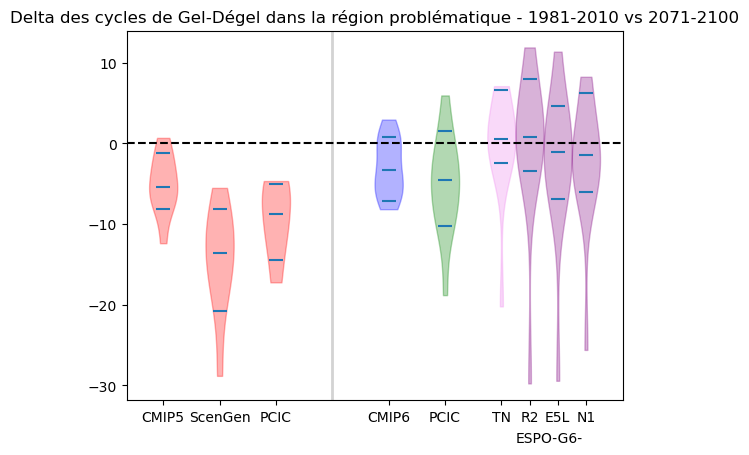

In [32]:
fig, ax = plt.subplots()
res = ax.violinplot(dfts, positions=[-3, -2, -1, 1, 2, 3, 3.5, 4, 4.5], showmedians=True, showextrema=False, quantiles=[[0.1, 0.9]] * len(dfts))
for poly, color in zip(res['bodies'], colors):
    poly.set_color(color)
ax.set_xticks([-3, -2, -1, 1, 2, 3, 3.5, 4, 4.5])
ax.set_xticklabels(['CMIP5', 'ScenGen', 'PCIC', 'CMIP6', 'PCIC', 'TN', 'R2', 'E5L', 'N1'])
ax.text(3.25, -37, 'ESPO-G6-')
ax.axvline(0, color='lightgray', linewidth=2)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Delta des cycles de Gel-Dégel dans la région problématique - 1981-2010 vs 2071-2100')

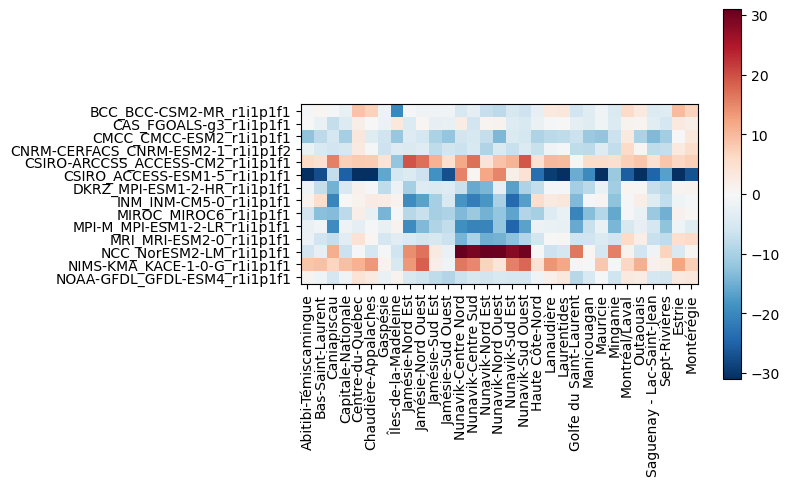

In [171]:
m = plt.imshow(dfteg6r.dlyfrzthw, vmin=-31, vmax=31, cmap=plt.cm.RdBu_r)
plt.yticks(ticks=range(14), labels=dfteg6r.realization.values)
plt.xticks(ticks=range(len(regions)), labels=regions.name, rotation='vertical')
plt.colorbar(m)

In [27]:
dc = xs.DataCatalog('/tank/scenario/catalogues/reconstruction.json')
dc.search(source='ERA5', variable='tas', xrfreq='MS').df.path

0    /tank/scenario/datasets/reconstruction/ECMWF/E...
Name: path, dtype: string

# Distributions de Tmin

In [19]:
ens = (
    xs.DataCatalog('/jarre/scenario/jlavoie/ESPO-G6/cat_ESPO-G6_RDRS.json')
    .search(domain='QC-rdrs', experiment='ssp245', variable='tasmin', xrfreq='D', processing_level='final')
    .to_dataset_dict(
        xarray_open_kwargs={'decode_timedelta': False}
    )
)

tmins = {
    dsid : xs.extract.clisops_subset(dd, region=probreg)
    for dsid, dd in ens.items()
}


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.
/home/pbourg/Pro

In [20]:
# CMIP6 raw
tmins.update({
    leaf.parent.parent.name: leaf.to_dataset()
    for leaf in dt['prob-reg']['day']['CMIP6'].leaves
    if leaf.name == 'raw' and leaf.parent.name == 'ssp245'
})
tmins['RDRS'] = xr.open_zarr('/exec/pbourg/ESPO-G/indsanal/day_RDRS_prob-reg.zarr')

In [21]:
import numpy as np
pts = np.linspace(230, 300, num=100)
def dropna(arr):
    return arr[~np.isnan(arr)]
kdes_pres = {
    k: gaussian_kde(dropna(tmin.tasmin.sel(time=slice('1991', '2020')).values.flatten()))
    for k, tmin in tmins.items()
}
kdes_fut = {
    k: gaussian_kde(dropna(tmin.tasmin.sel(time=slice('2071', '2100')).values.flatten()))
    for k, tmin in tmins.items() if k != 'RDRS'
}

In [37]:
dd = {}
for tt, kdes in [('pres', kdes_pres), ('fut', kdes_fut)]:
    for k, kde in kdes.items():
        if k.startswith('CMIP6'): # ESPO
            m = k.split('_')[3]
            p = f'{tt}/ESPO/{m}'
        elif k == 'RDRS':
            p = f'{tt}/RDRS/RDRS'
        else:
            p = f'{tt}/RAW/{k}'
        dd[p] = xr.DataArray(kde(pts), dims=('T',), coords={'T': pts}, name='pdf')
kt = DataTree.from_dict(dd)

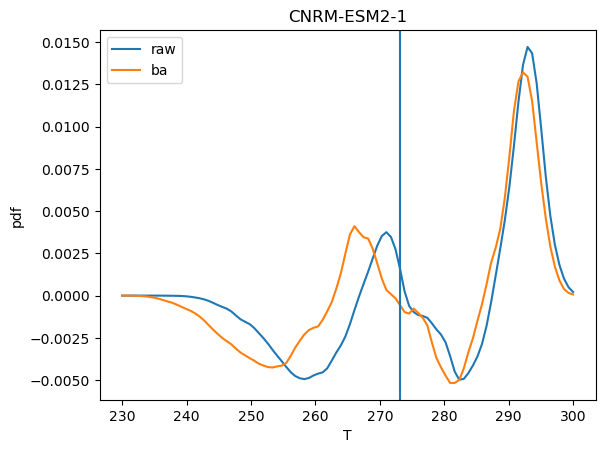

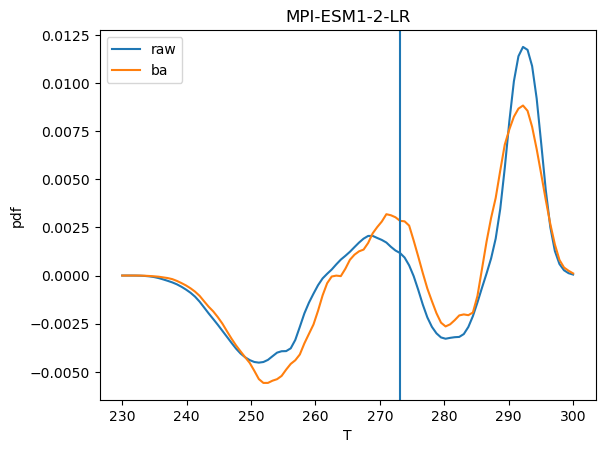

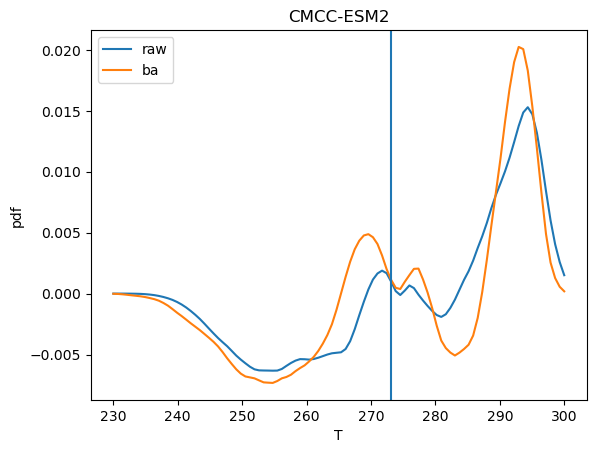

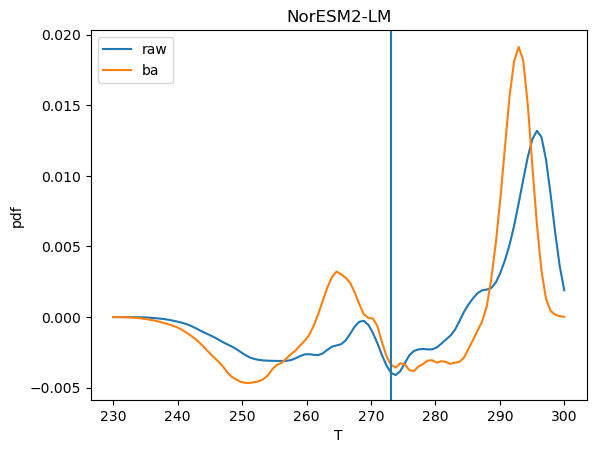

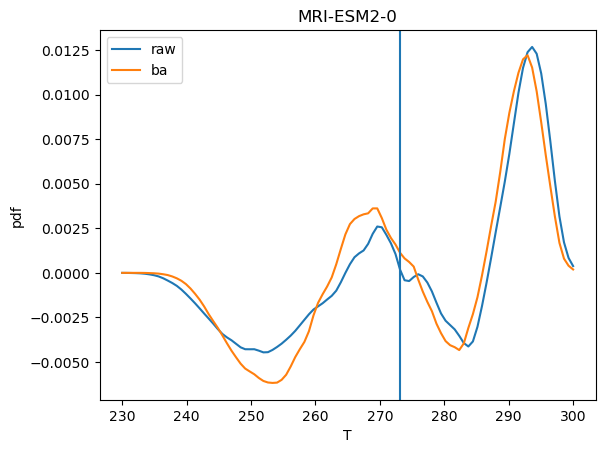

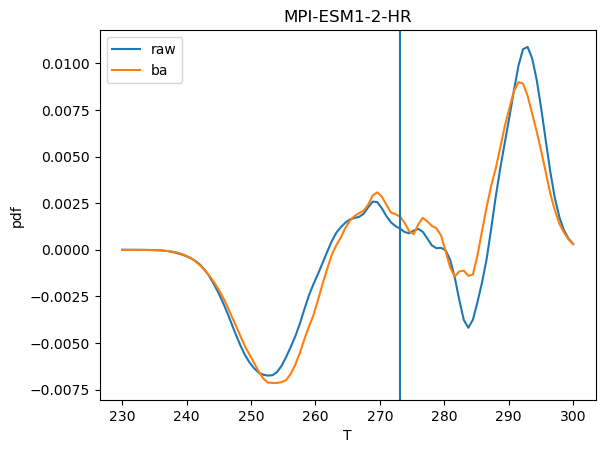

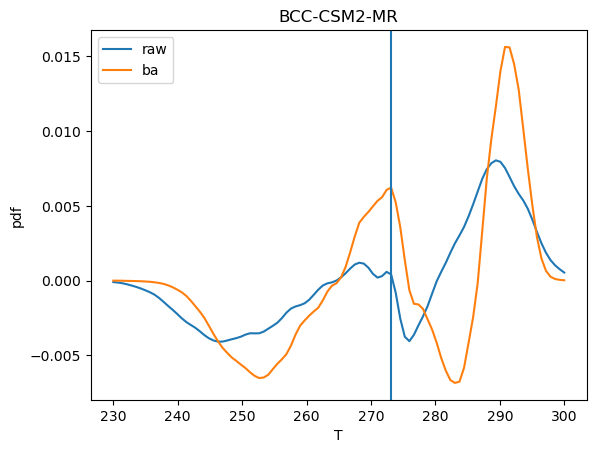

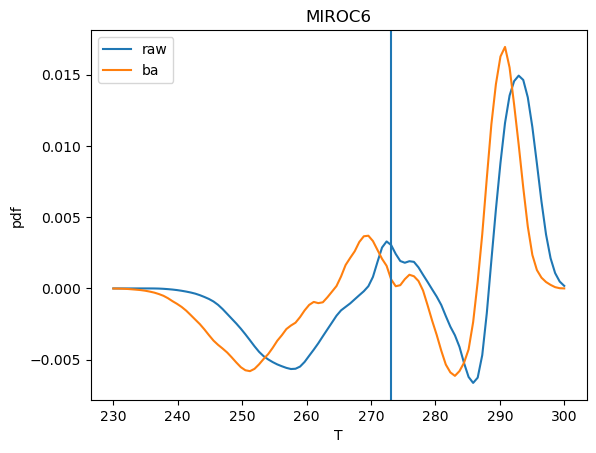

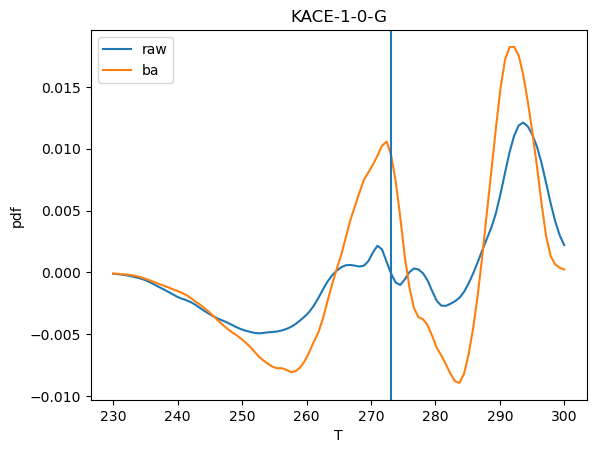

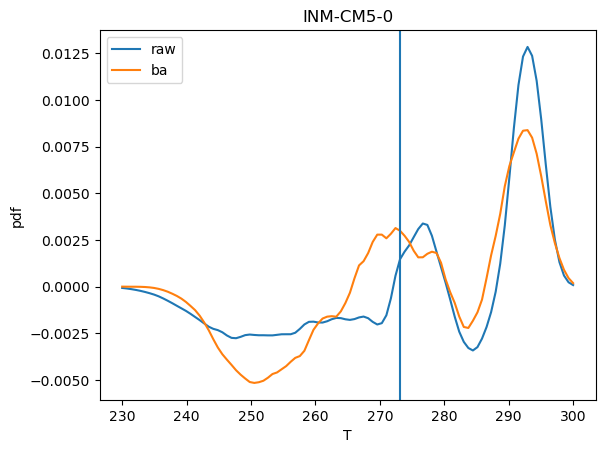

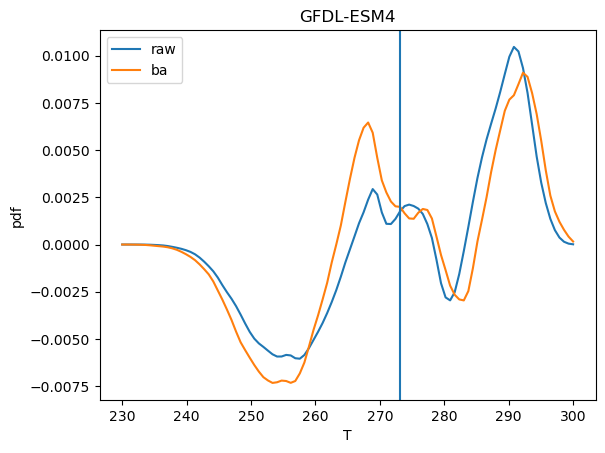

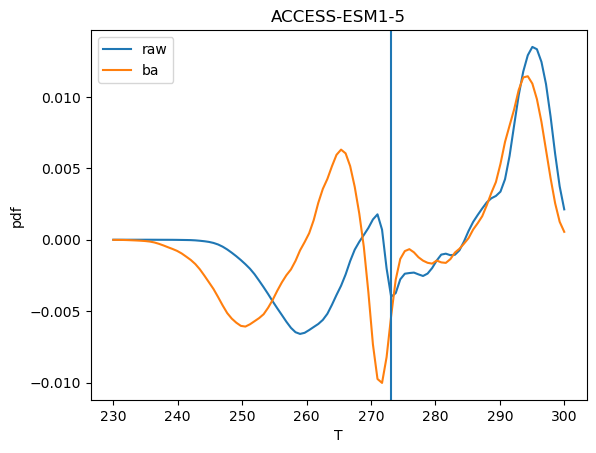

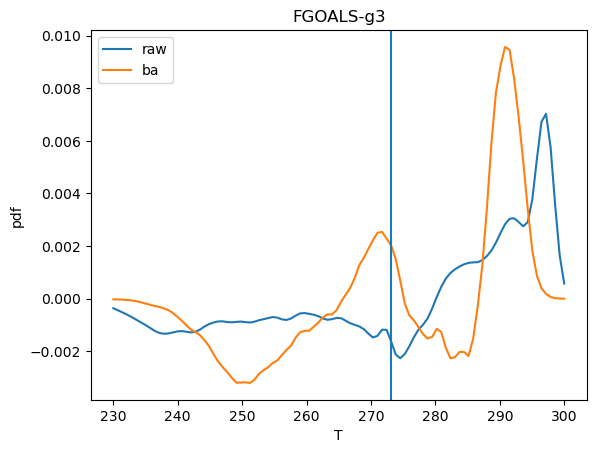

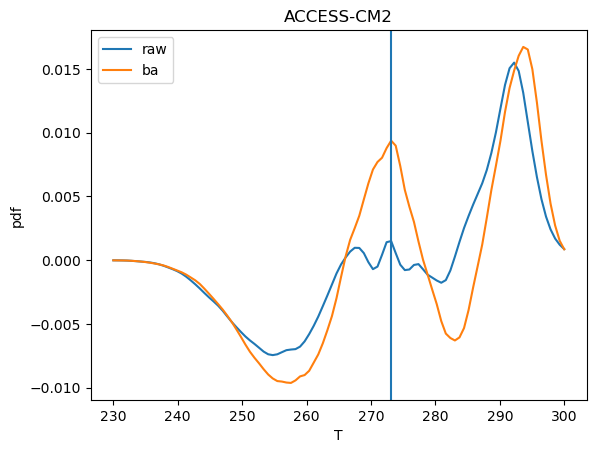

In [45]:
for l in kt['fut']['RAW'].leaves:
    m = l.name
#kt[ 'pres/RDRS/RDRS']['pdf'].plot(label='RDRS')
    fig, ax = plt.subplots()
    (kt[f'fut/RAW/{m}']['pdf'] - kt[f'pres/RAW/{m}']['pdf']).plot(label='raw', ax=ax)
    (kt[f'fut/ESPO/{m}']['pdf'] - kt[f'pres/ESPO/{m}']['pdf']).plot(label='ba', ax=ax)
    ax.axvline(273.15)
    ax.legend()
    ax.set_title(m)

CMIP6_ScenarioMIP_BCC_BCC-CSM2-MR_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_NCC_NorESM2-LM_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_CMCC_CMCC-ESM2_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_NOAA-GFDL_GFDL-ESM4_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp245_r1i1p1f2_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_CAS_FGOALS-g3_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_MRI_MRI-ESM2-0_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_MIROC_MIROC6_ssp245_r1i1p1f1_global.QC-rdrs.final.D
CMIP6_ScenarioMIP_MPI-M_MPI-E

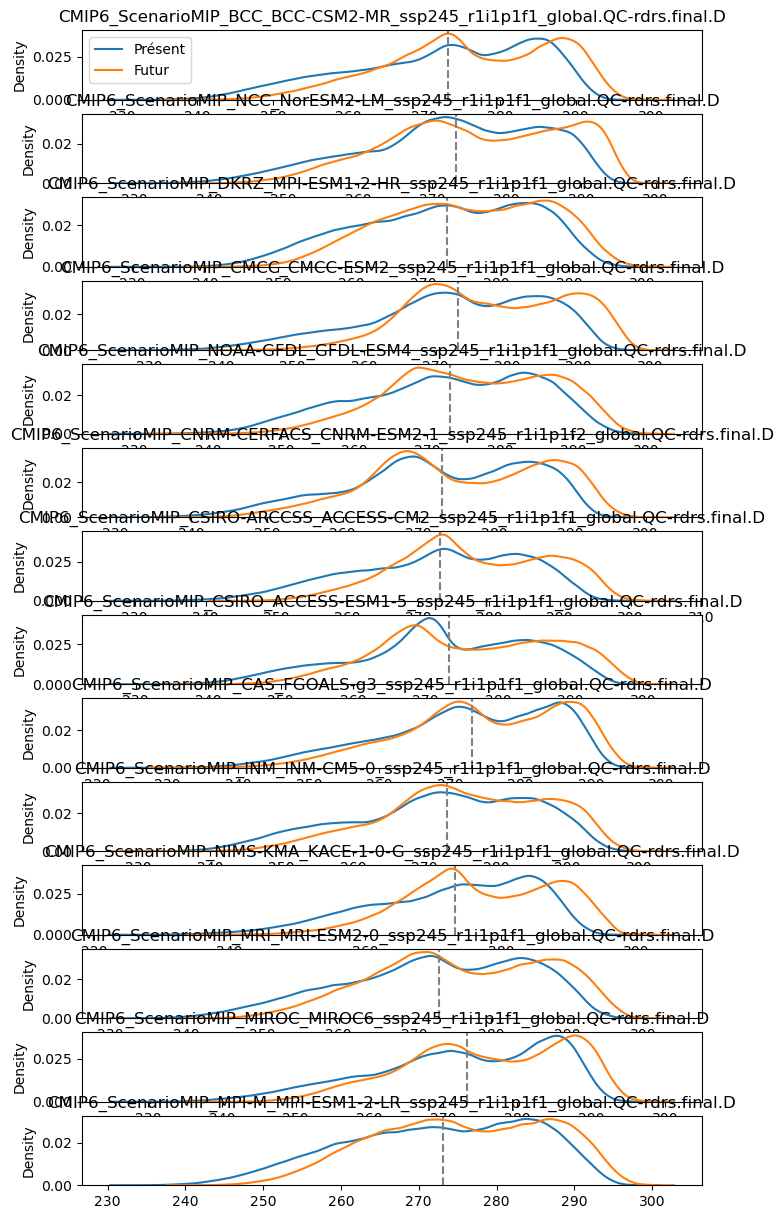

In [269]:
fig, axs = plt.subplots(14, 1, figsize=(8, 15))
for ax, (dsid, tmin) in zip(axs, tmins.items()):
    print(dsid)
    sns.kdeplot(
        tmin
        .sel(time=slice('1981', '2010'))
        .tasmin
        .values.flatten(),
        common_norm=True,
        label='Présent',
        ax=ax
    )
    sns.kdeplot(
        tmin
        .sel(time=slice('2071', '2100'))
        .tasmin
        .values.flatten(),
        common_norm=True,
        label='Futur',
        ax=ax
    )
    ax.axvline(273.15, color='gray', linestyle='--')
    ax.set_title(dsid)
axs[0].legend()

# Catalogue

In [2]:
pcat = xs.ProjectCatalog('/exec/pbourg/ESPO-G/indsanal/catalog.json', overwrite=True, create=True, project={'id': 'analysis'})

Successfully wrote ESM catalog json file to: file:///exec/pbourg/ESPO-G/indsanal/catalog.json


In [47]:
for zarr in root.glob('day_*.zarr'):
    parts = zarr.stem.split('_')
    dom = parts[-1]
    if parts[1].startswith('CanDCS'):
        src = 'pcic'
        mip = parts[2]
        mod = parts[5]
        if mip == 'CMIP5':
            scen = f"rcp{parts[6][-2:]}"
        else:
            scen = parts[6]
    elif parts[2] == 'MRCC5':
        src = 'mrcc5'
        mip = parts[1]
        mod = parts[3]
        scen = parts[6]
    elif parts[1].startswith('CMIP'):
        src = 'raw'
        mip = parts[1]
        mod = parts[4]
        scen = parts[5]
    elif parts[1] == 'ScenGen':
        src = parts[1]
        mip = parts[2]
        mod = parts[4]
        scen = parts[5]
    elif parts[1] == 'ESPO-TN':
        src = parts[1]
        mip = parts[2]
        mod = parts[5]
        scen = parts[6]
    elif parts[1] == 'RDRS':
        continue
    else:
        src = parts[1]
        mip = parts[2]
        mod = parts[5]
        scen = parts[6]
    yrzarr = zarr.parent / zarr.name.replace('day_', 'yr_')
    if not yrzarr.is_dir():
        yrzarr = zarr.parent / zarr.name.replace('day_', 'mon_')
    
    meta = {
        'source': mod,
        'mip_era': mip,
        'experiment': scen,
        'bias_adjust_project': src,
        'format': 'zarr',
        'date_start': '1950-01-01',
        'date_end': '2100-12-31',
        'domain': dom,
    }
    pcat.update(pd.Series(
        {
            'xrfreq': 'D',
            'processing_level': 'biasajusted',
            'variable': ['tasmin', 'tasmax', 'dtr'],
            'path': str(zarr),
            **meta
        }
    ))
    pcat.update(pd.Series(
        {
            'xrfreq': 'mon',
            'processing_level': 'indicators',
            'variable': ['dlyfrzthw', 'dtr', 'mask'],
            'path': str(yrzarr),
            **meta
        }
    ))

In [48]:
pcat.df['id'] = xs.catalog.generate_id(pcat.df)

In [49]:
pcat.update()

In [14]:
cat = xs.DataCatalog('/exec/pbourg/ESPO-G/indsanal/catalog.json')
cat

,unique
id,110
type,0
processing_level,2
bias_adjust_institution,0
bias_adjust_project,6
mip_era,2
activity,0
driving_institution,0
driving_model,0
institution,0


In [15]:
cat.search(domain='ok-reg').unique()

id                         [raw_CMIP6_MPI-ESM1-2-LR_ssp245_ok-reg, pcic_C...
type                                                                      []
processing_level                                   [biasajusted, indicators]
bias_adjust_institution                                                   []
bias_adjust_project                                              [raw, pcic]
mip_era                                                       [CMIP6, CMIP5]
activity                                                                  []
driving_institution                                                       []
driving_model                                                             []
institution                                                               []
source                     [MPI-ESM1-2-LR, NorESM2-LM, MRI-ESM2-0, MPI-ES...
experiment                                                   [ssp245, rcp45]
member                                                                    []